**reqs**

python==3.13.0  
pandas==2.2.3  
notebook==7.3.3  
numpy==1.26.4  
scikit-learn==1.6.1  
sweetviz==2.3.1  
lightgbm==4.6.0  
optuna-integration[sklearn]==4.2.1  
shap==0.47.1  
matplotlib==3.10.1  
seaborn==0.13.2

# Загружаем данные

Рассмотрим данные из соревнования по предсказанию стоимости жилья

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
import sweetviz as sv
from sklearn.model_selection import train_test_split
import lightgbm
import optuna
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

In [2]:
import warnings
# Фильтруем маловажные предупреждения
warnings.filterwarnings("ignore", category=UserWarning, 
                       module="sklearn.preprocessing._encoders")
warnings.filterwarnings("ignore", category=UserWarning,
                       module="sklearn.utils.validation")

In [3]:
# !wget  -O 'train.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'
# Изначальный код загрузки не сработал, датасет загружен вручную

In [4]:
data = pd.read_csv("train.csv")
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

    Ответ: Id не несёт в себе никакой полезной информации. Простые модели будут пытаться найти взаимосвязи, которых нет. А сложные могут попытаться связать id с целевой переменной, что приведёт к полному переобучению.

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

    Ответ: Валидационная выборка - единственный способ получить промежуточную оценку во время обучения или подбора гиперпараметров. Тестовые данные для этого не подходят, они должны оставаться эталонно-нетронутыми до финального теста, ведь именно на них мы проверяем модель на степень переобучения и общую адекватность.

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

    Ответ: Фиксация рандомности разделения. Это гарантирует что при повторном запуске кода данные разделятся так-же как и в предыдущие разы. То-же относится к некоторым моделям, предусматривающим рандомизацию в расчётах. Без константы случайности результаты экспериментов будут невоспроизводимыми.

In [5]:
# Константа случайности
RANDOM_STATE = 10

# Задание
- 1) Проведите EDA анализ данных
- 2) Выберите наиболее релевантные факторы для прогноза
- 3) Подберите лучшую модель (используйте в качестве метрики качества показатель RMSE
- 4) Проверьте качество данной модели - на сколько она точна, насколько стабильна, насколько правильно специфирована

## Разведочный анализ данных и предобработка

Начнём с базового ознакомления с данными. Типы, количество, названия признаков - нет ничего надёжнее .info()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

80 признаков, 1460 записей. Сразу видно наличие пропусков. Проведём более глубокий EDA автоматизированными инструментами.

                                             |                                             | [  0%]   00:00 ->…


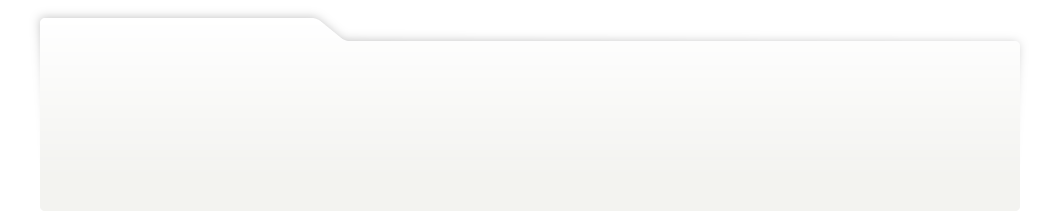
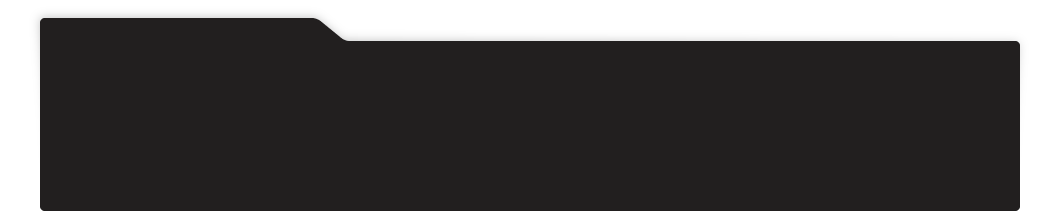
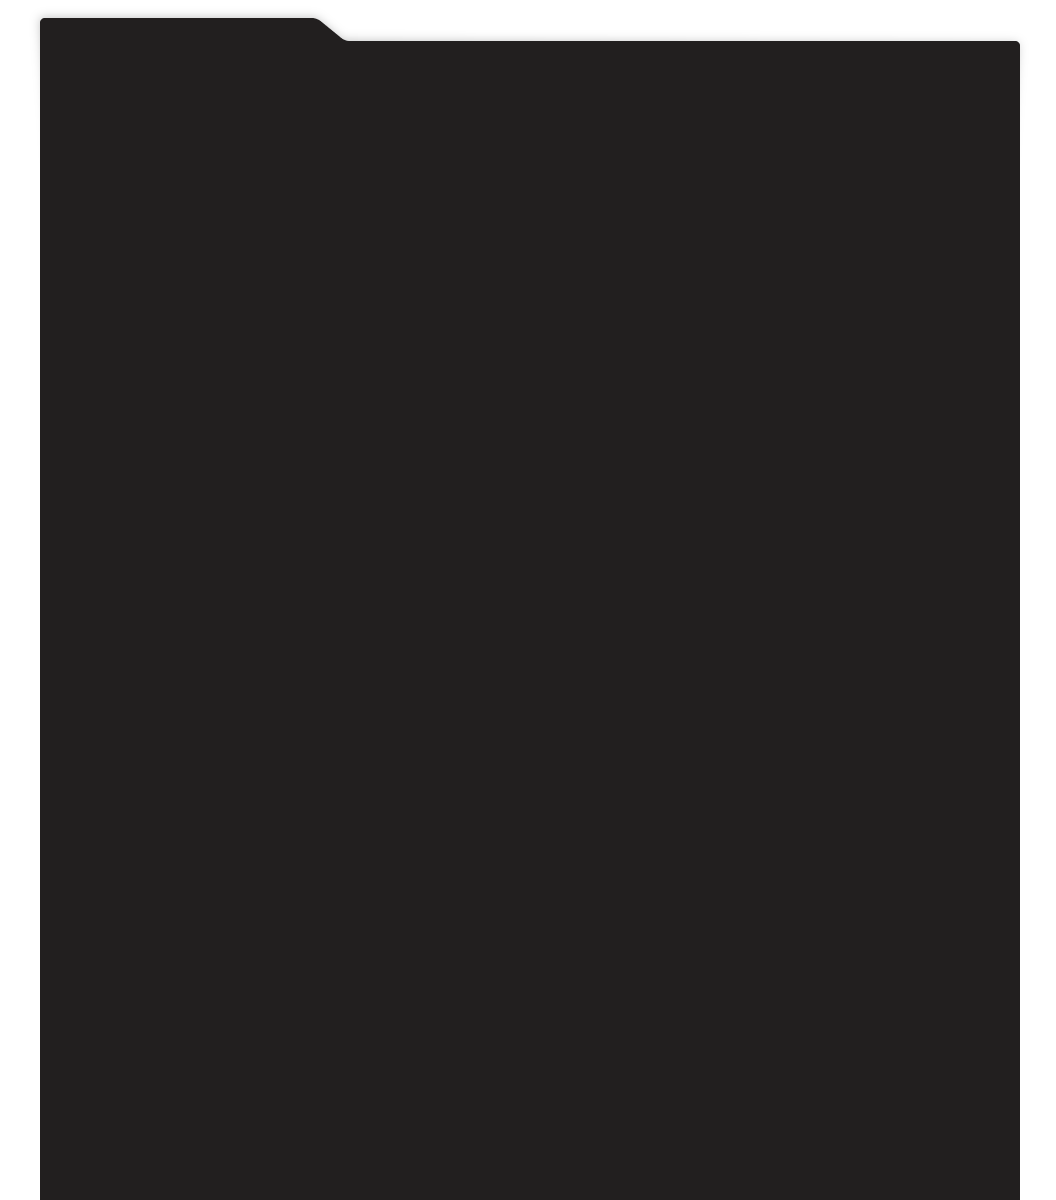
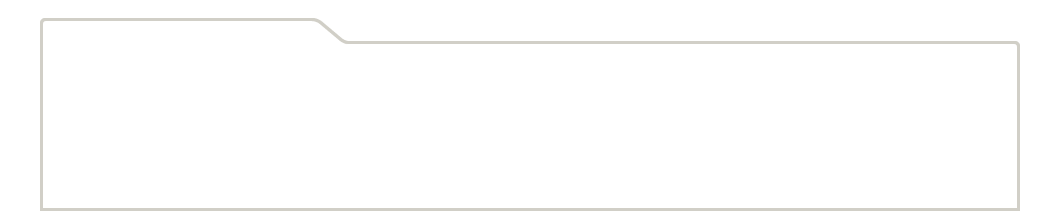
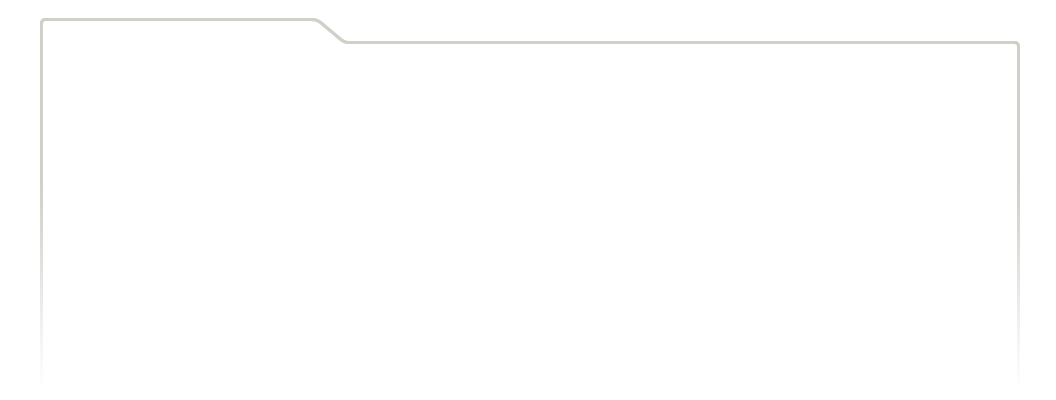
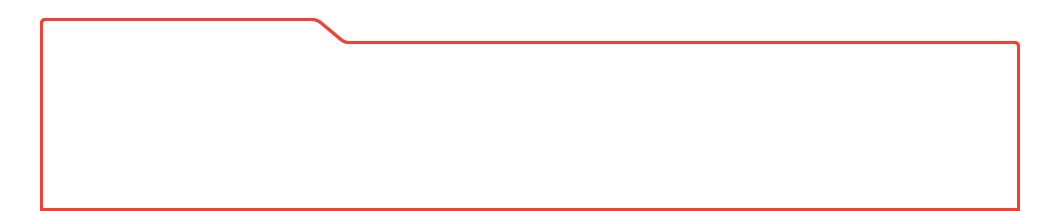
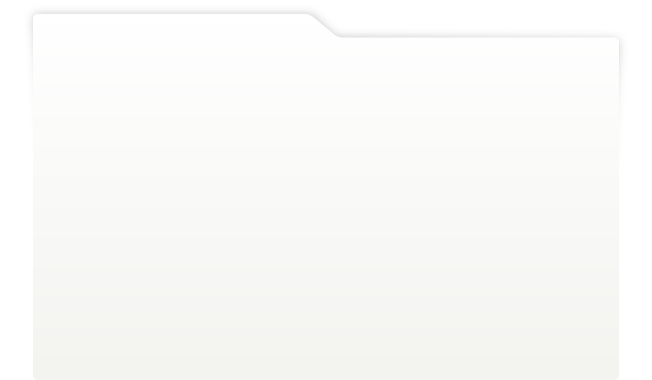
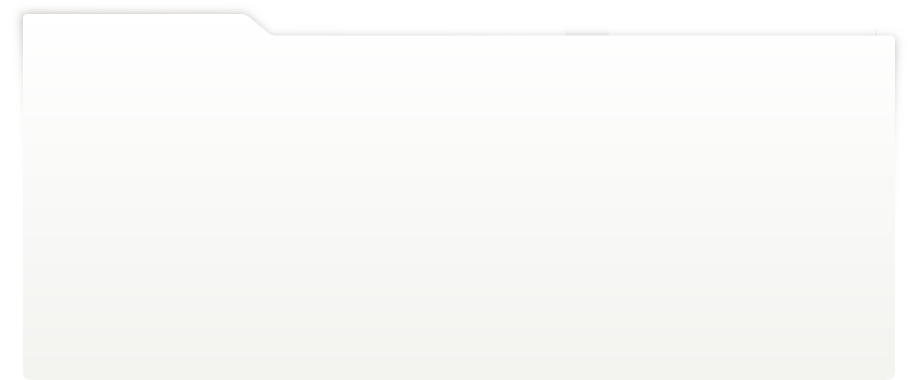
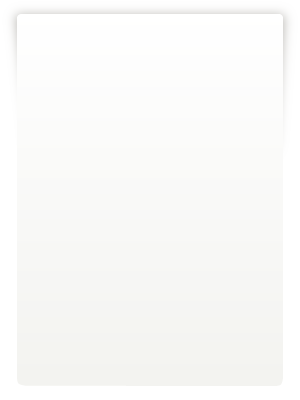
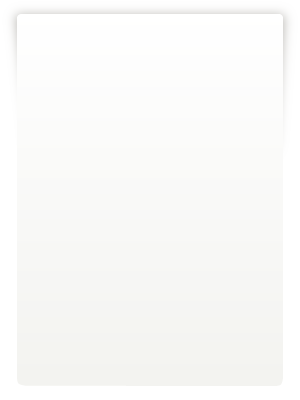
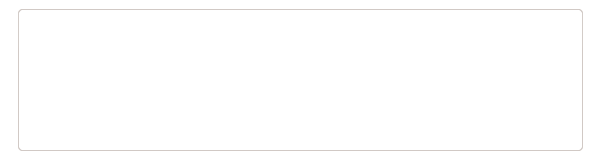
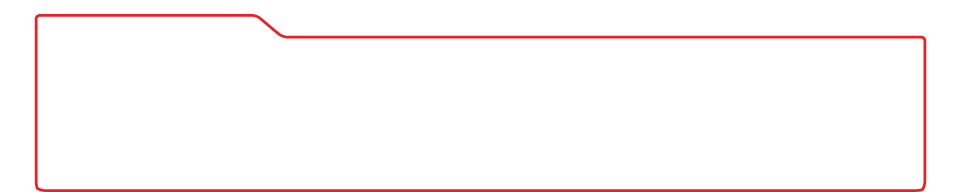
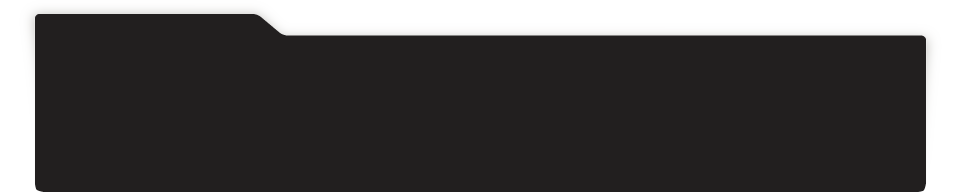
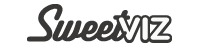
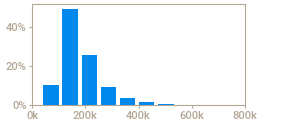
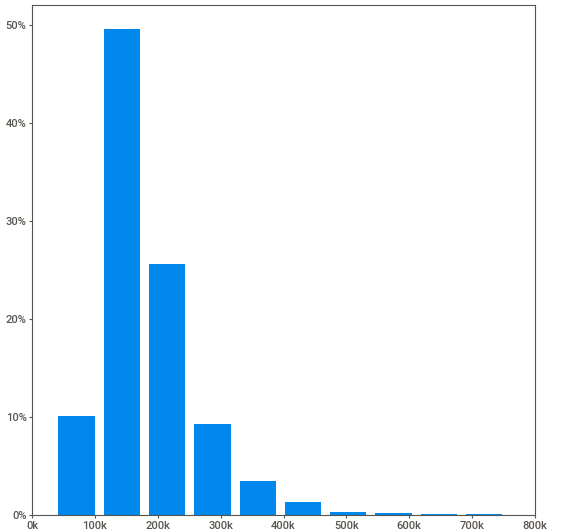
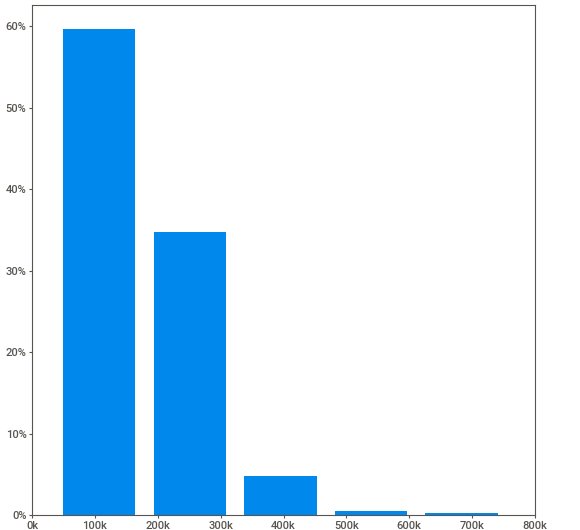
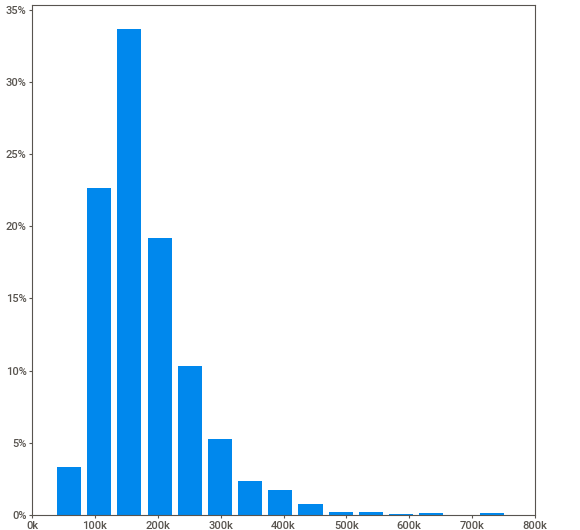
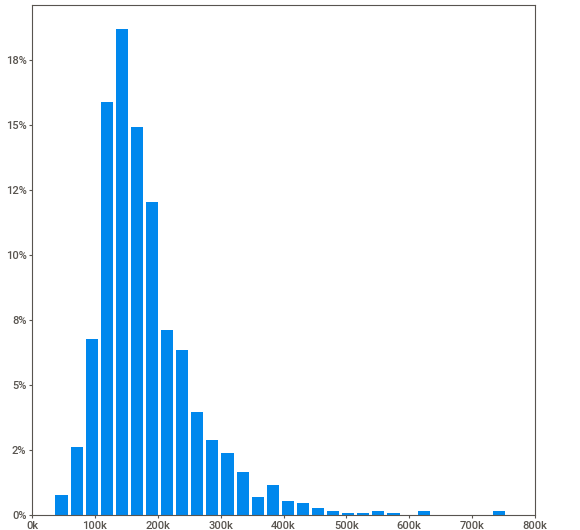
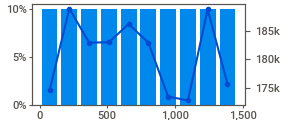
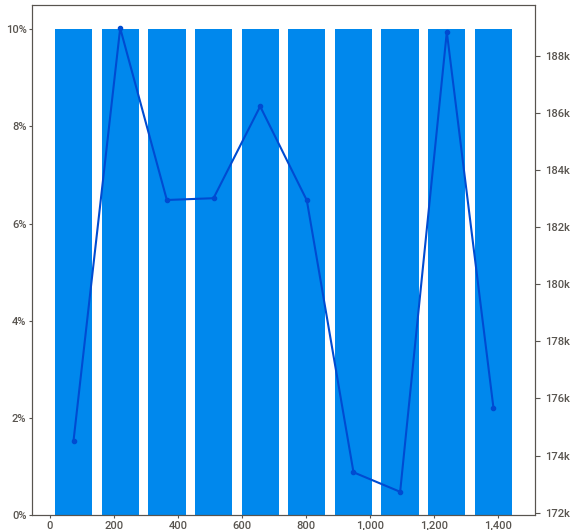
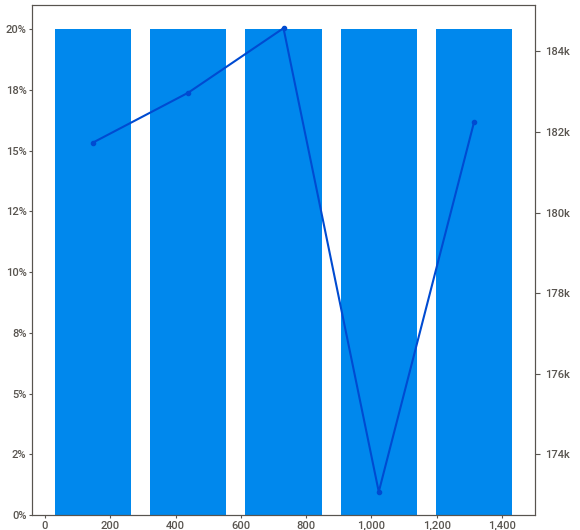
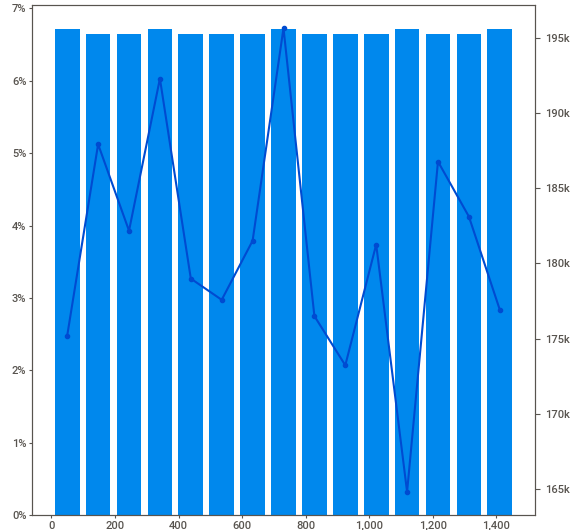
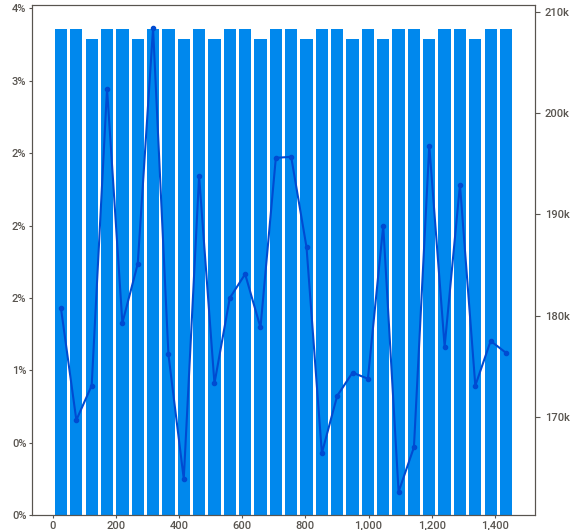
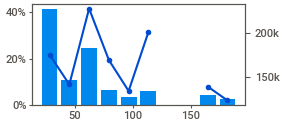
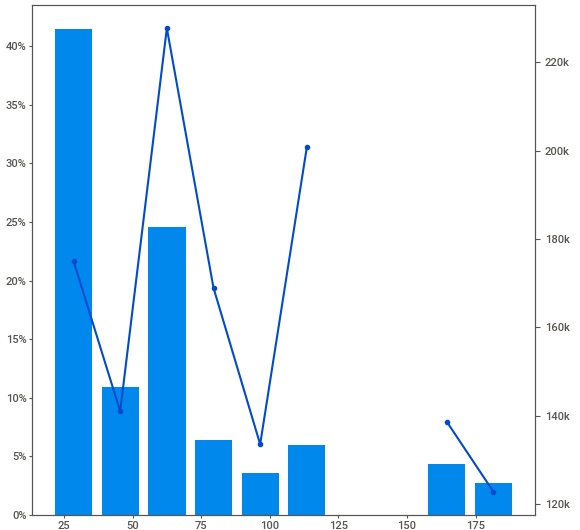
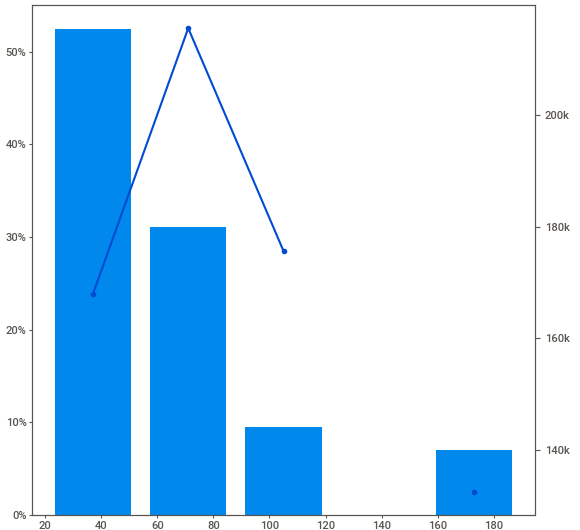
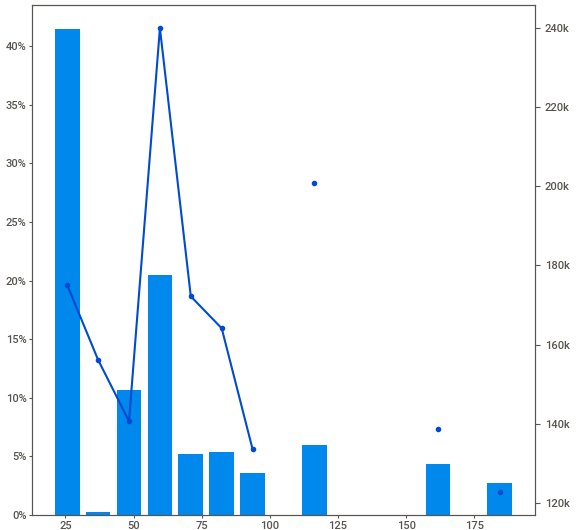
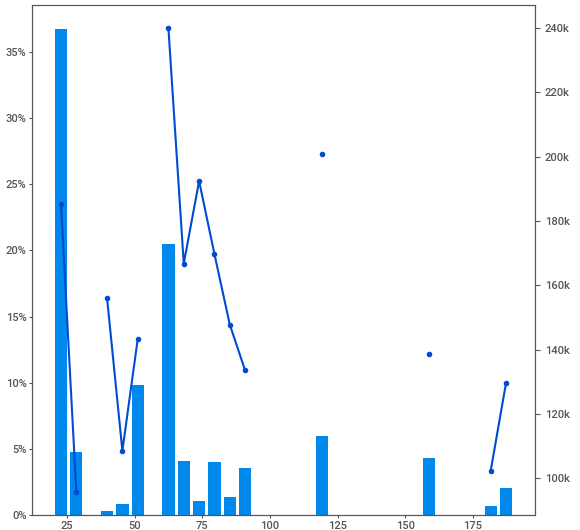
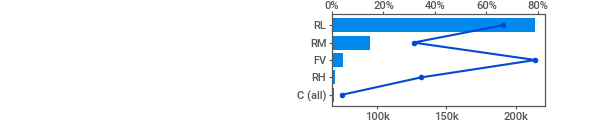
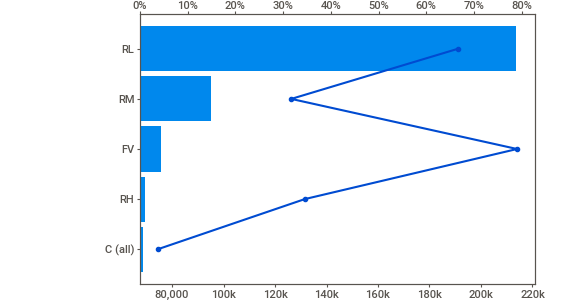
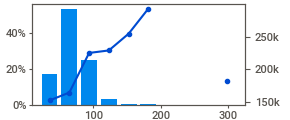
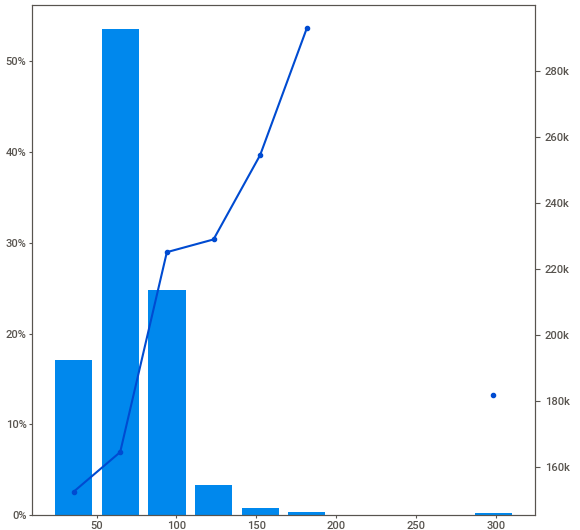
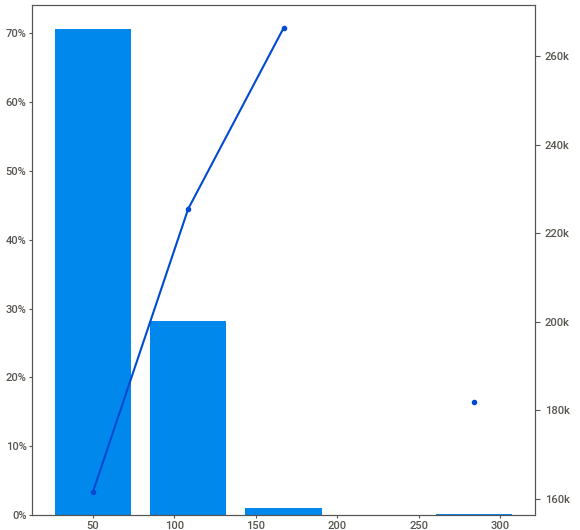
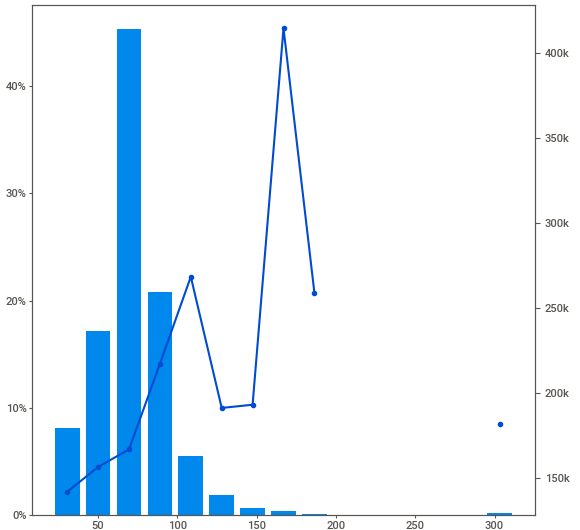
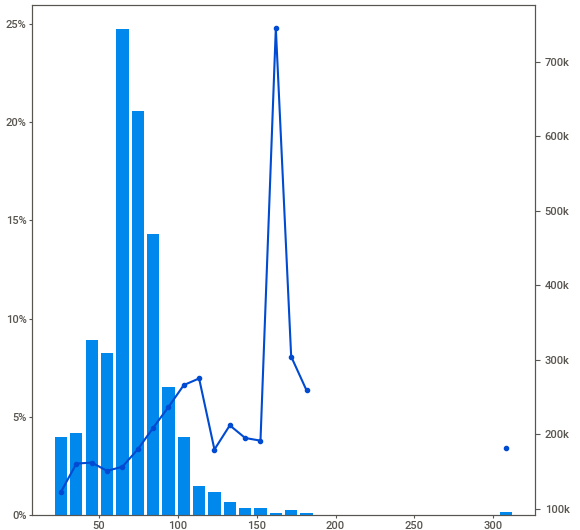
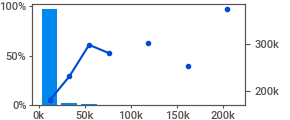
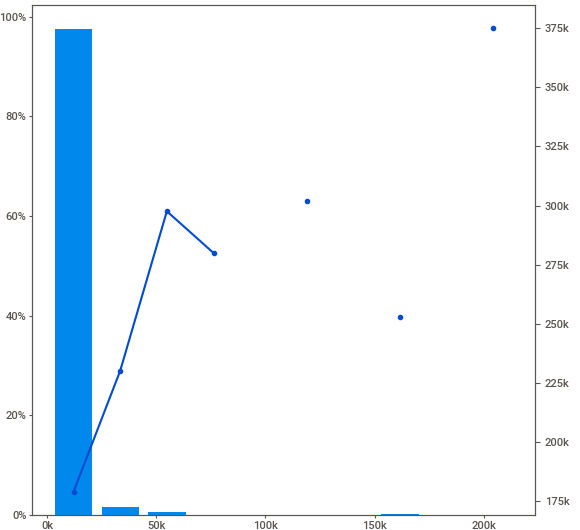
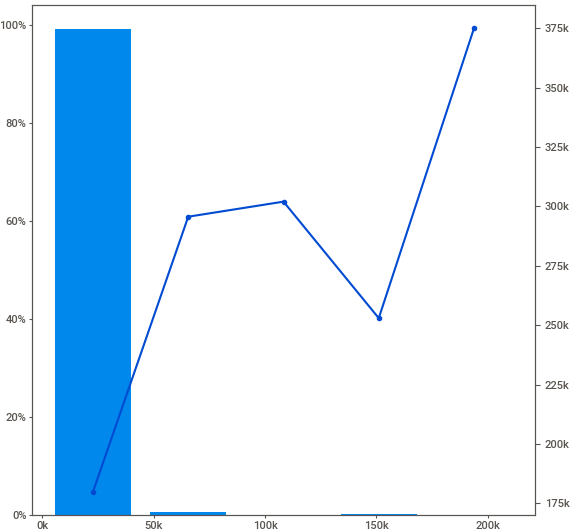
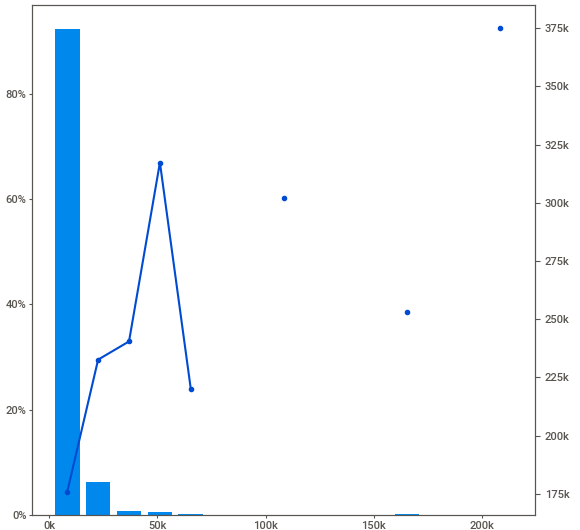
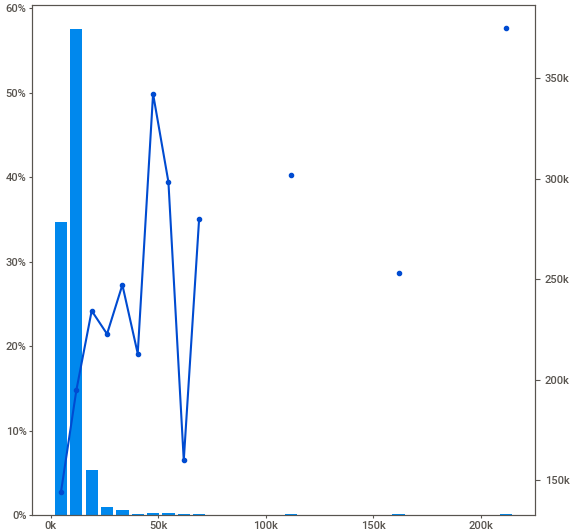
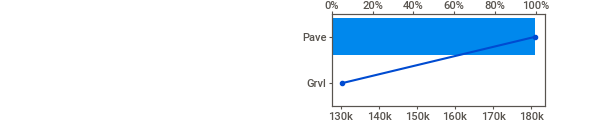
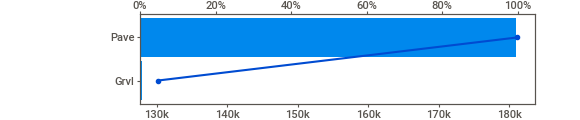
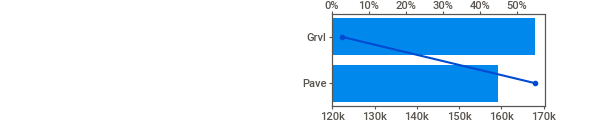
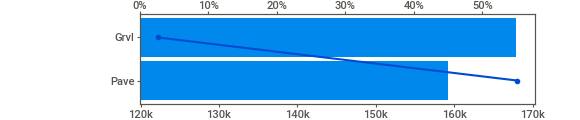
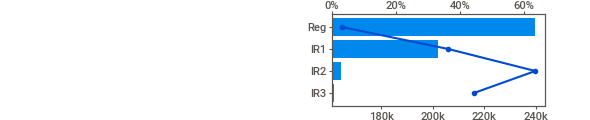
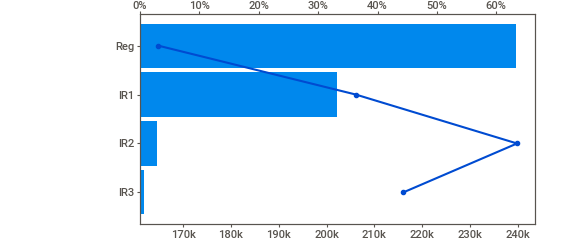
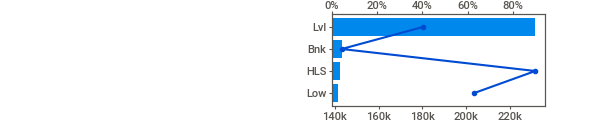
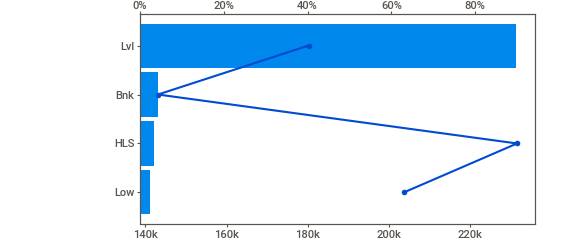
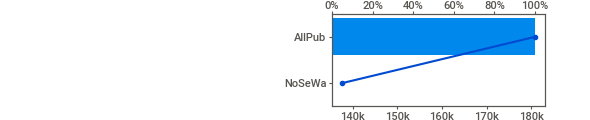
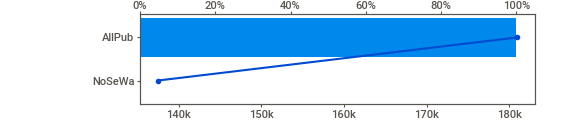
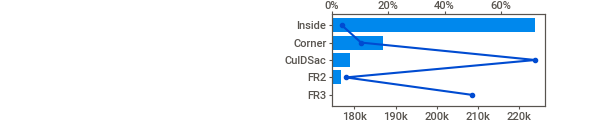
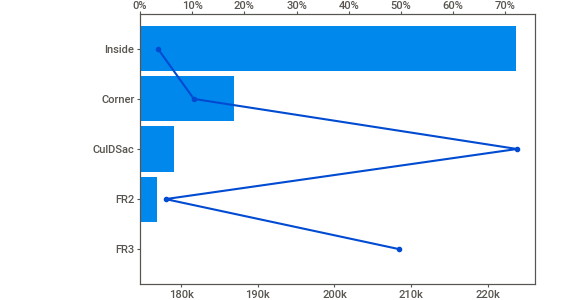
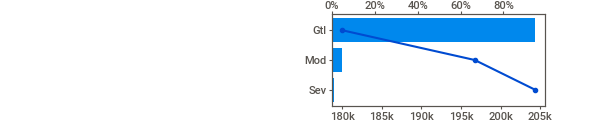
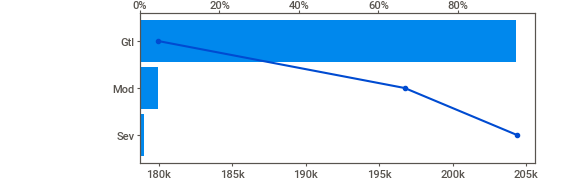
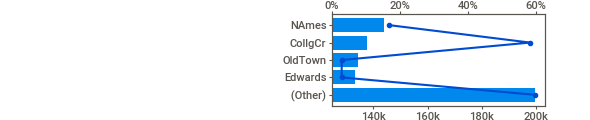
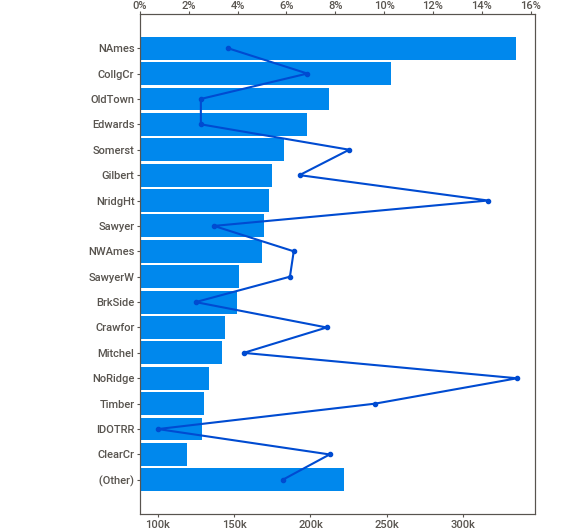
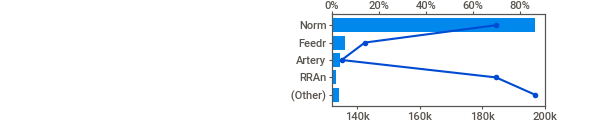
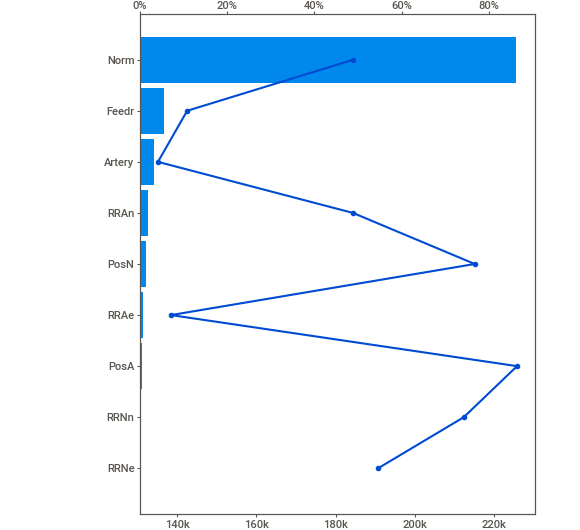
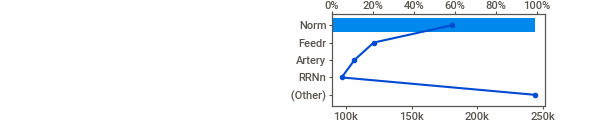
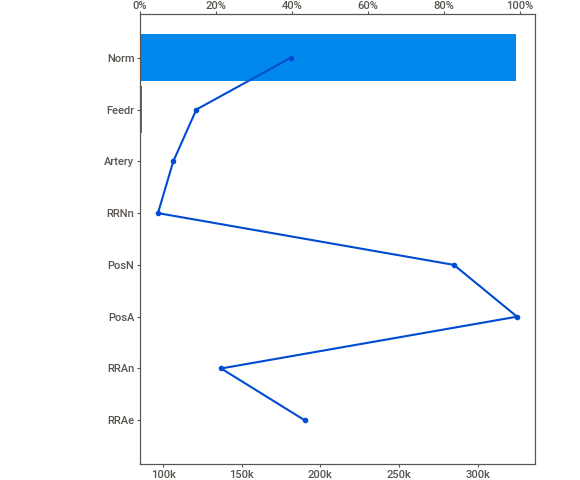
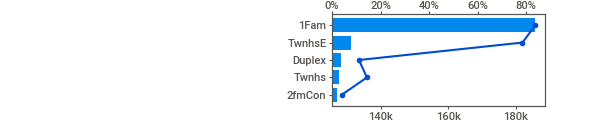
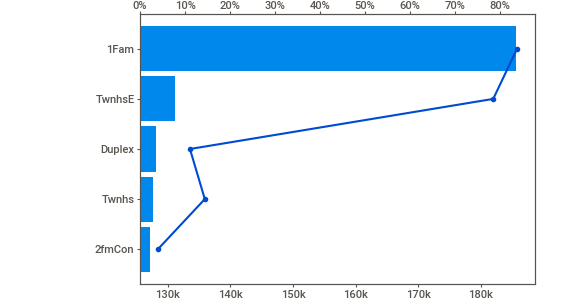
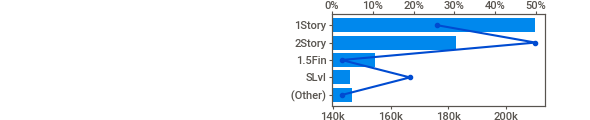
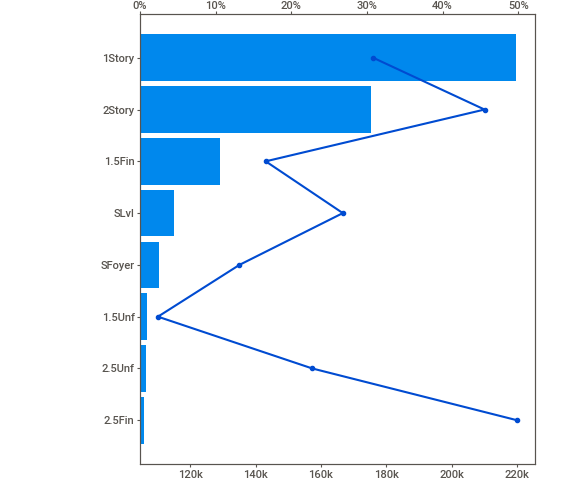
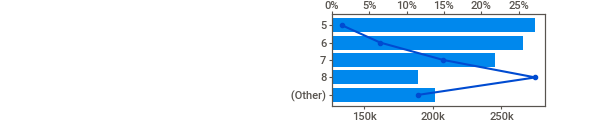
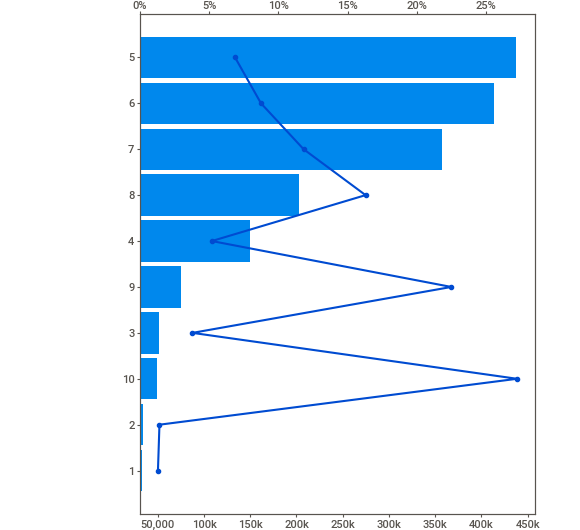
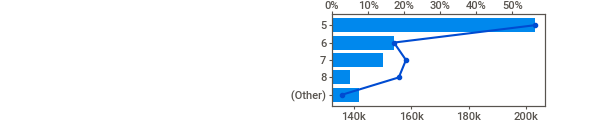
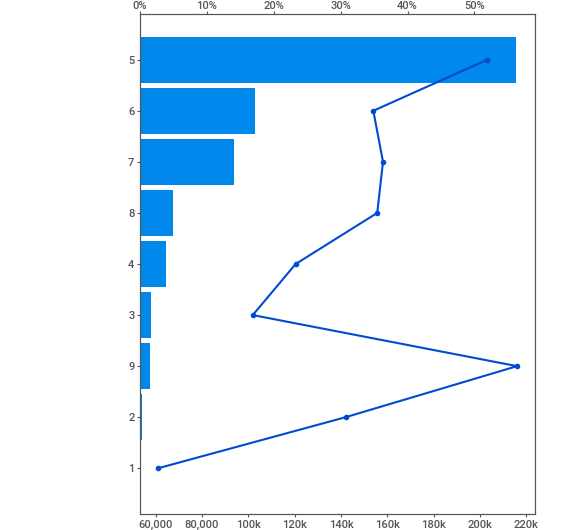
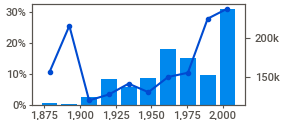
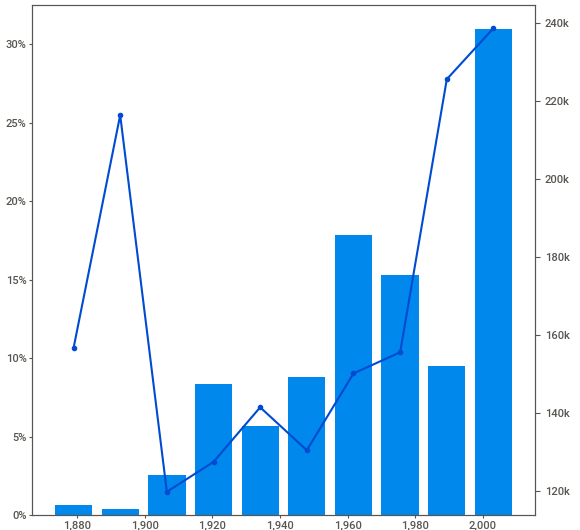
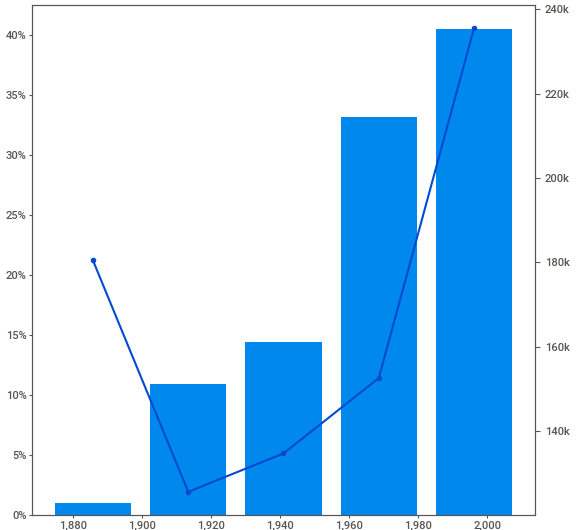
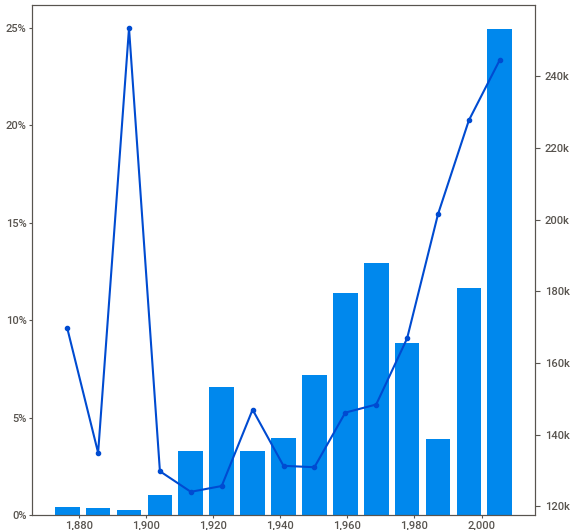
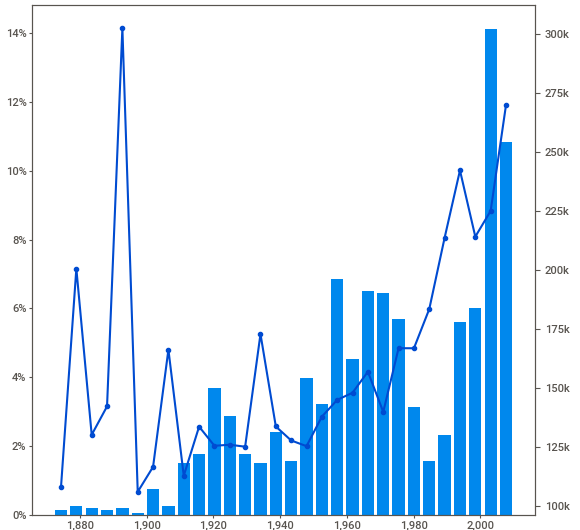
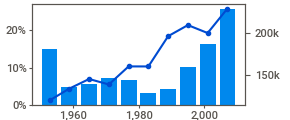
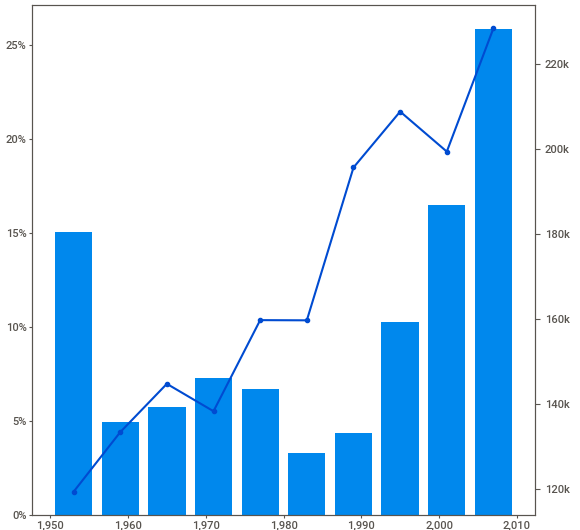
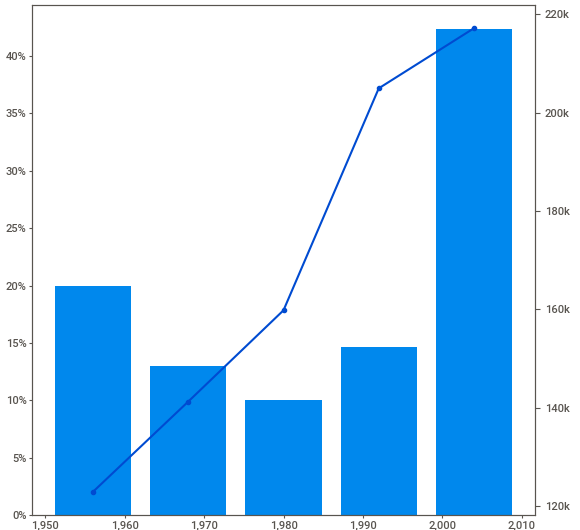
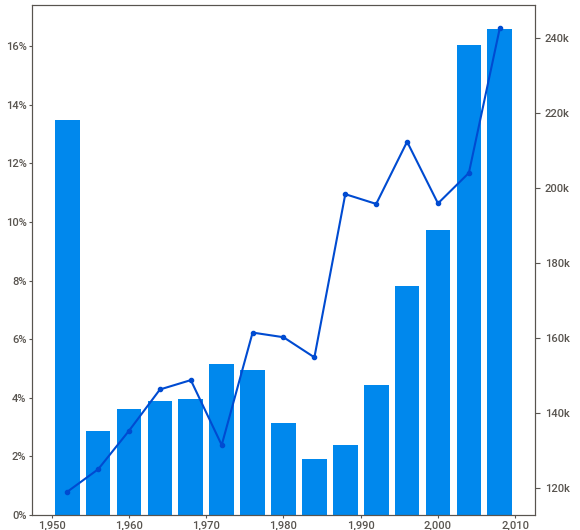
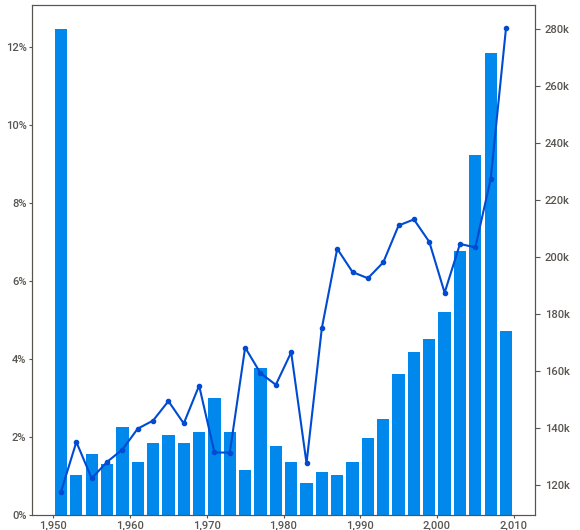
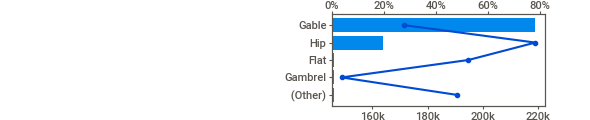
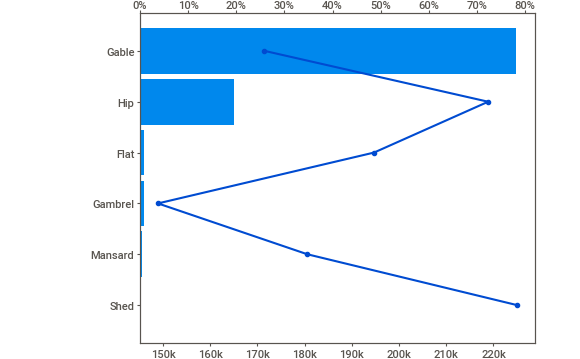
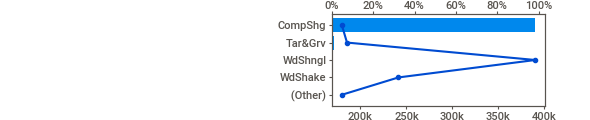
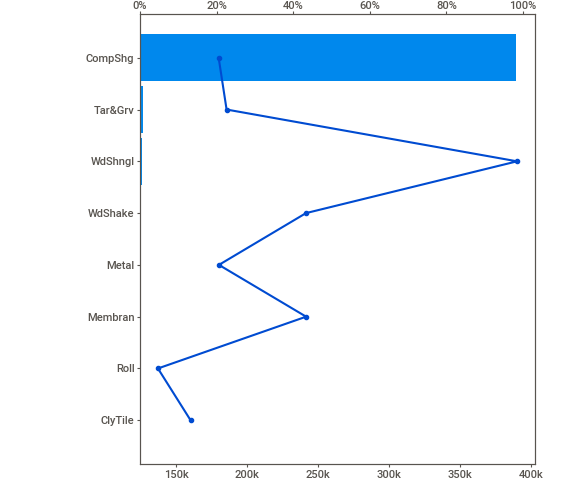
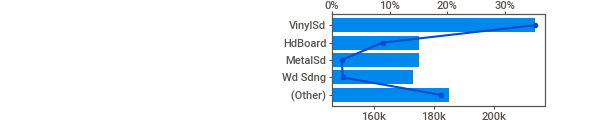
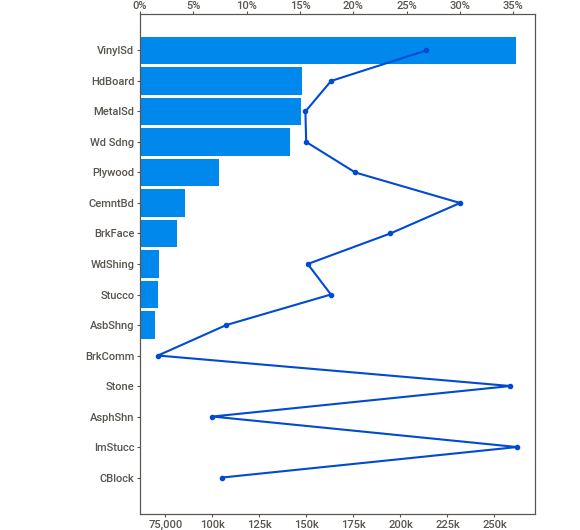
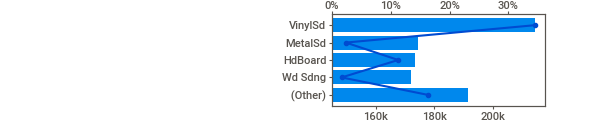
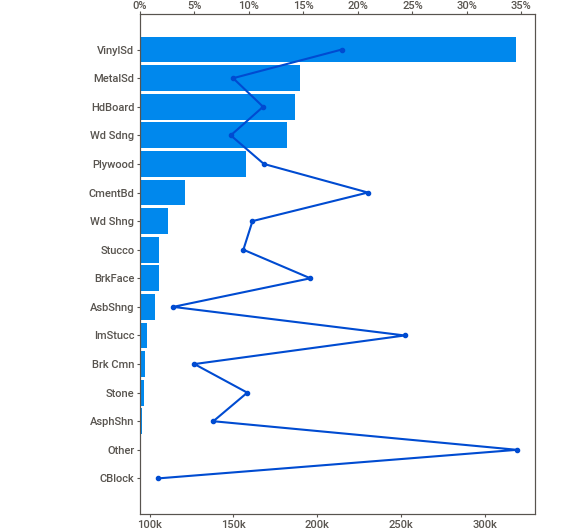
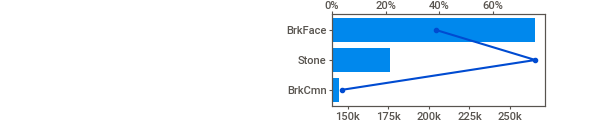
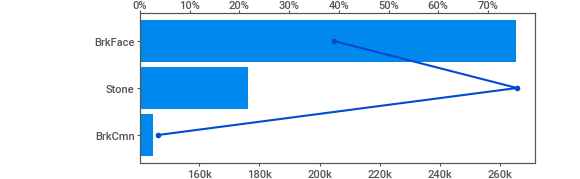
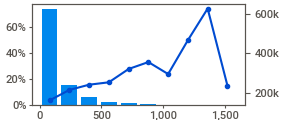
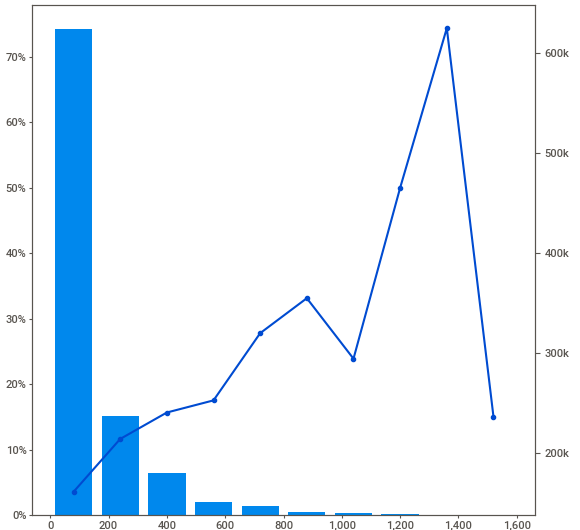
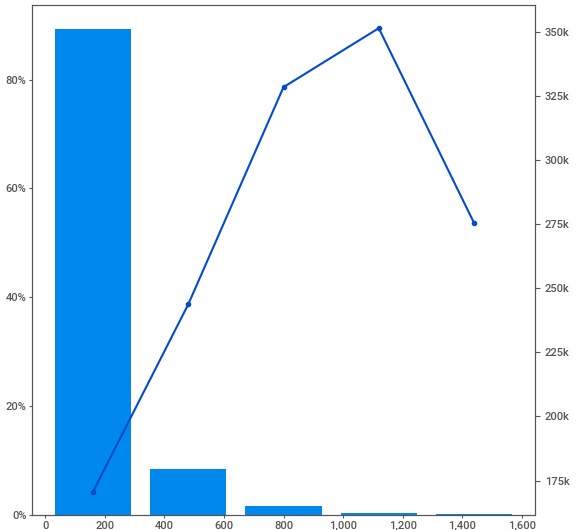
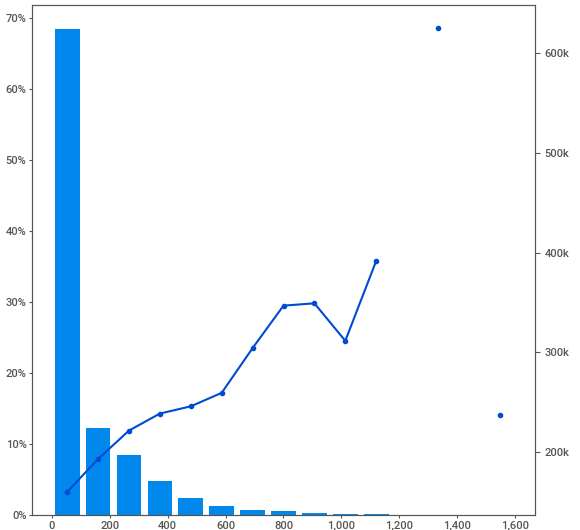
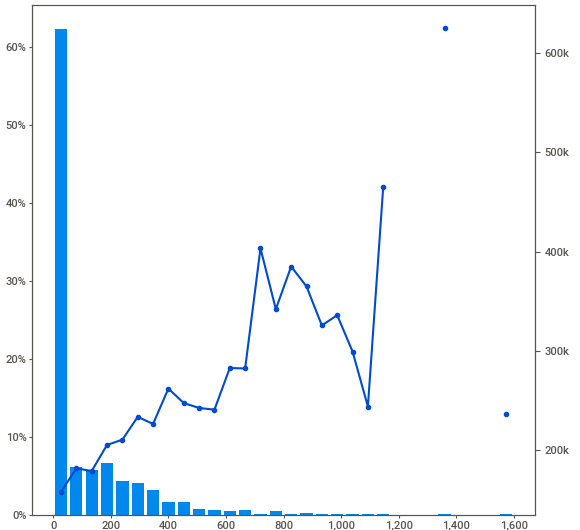
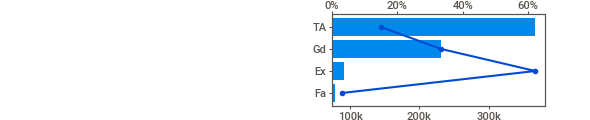
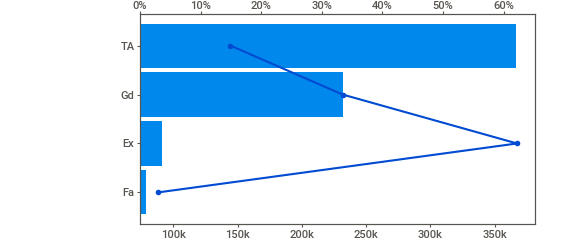
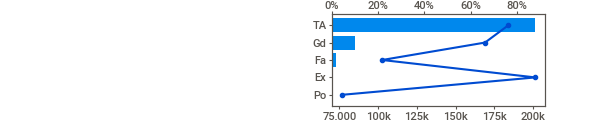
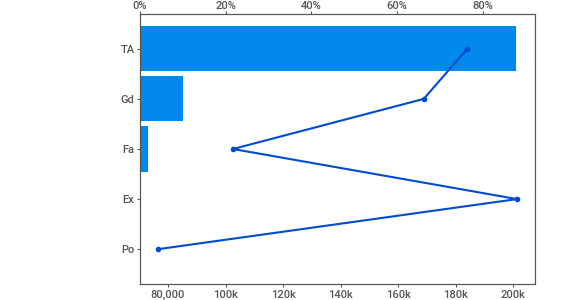
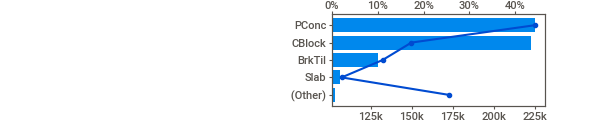
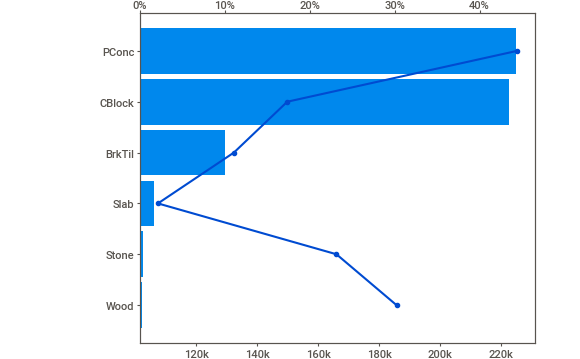
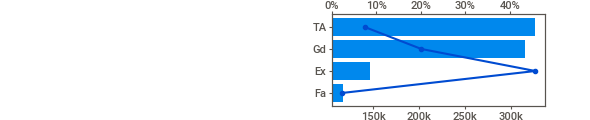
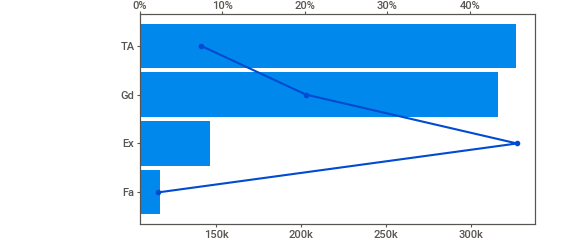
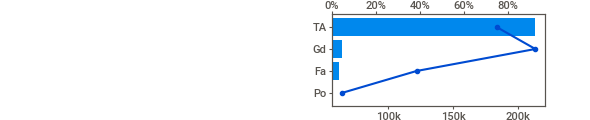
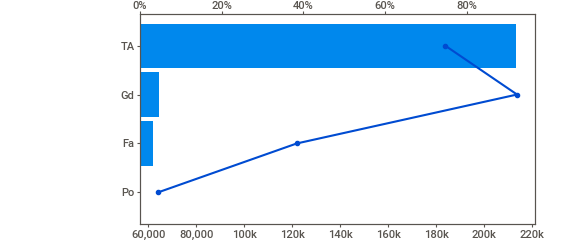
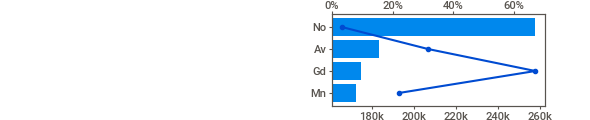
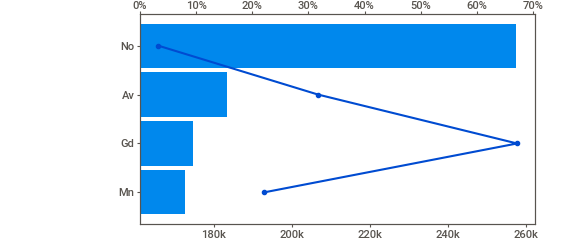
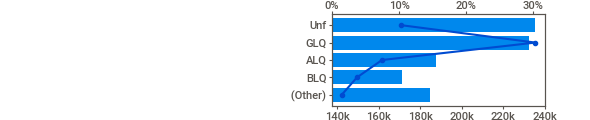
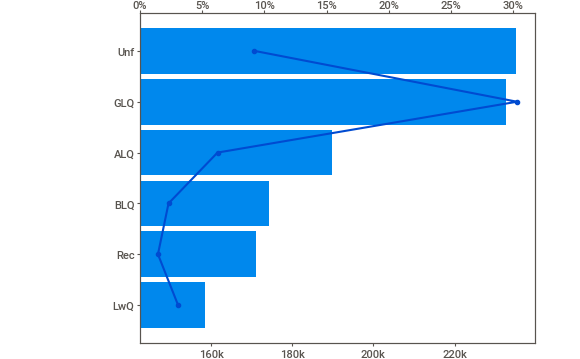
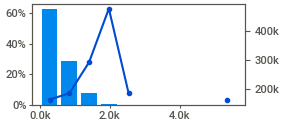
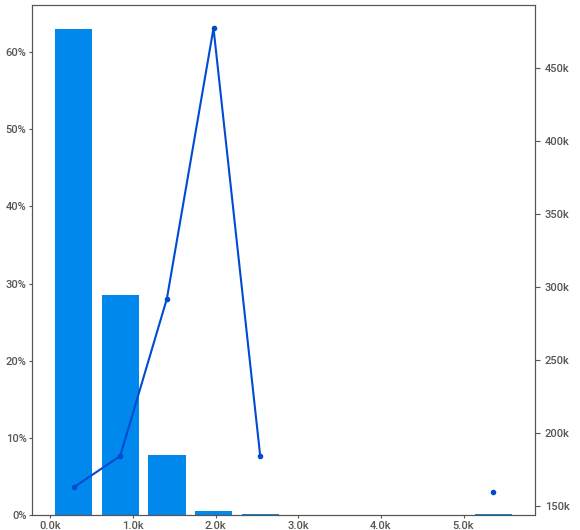
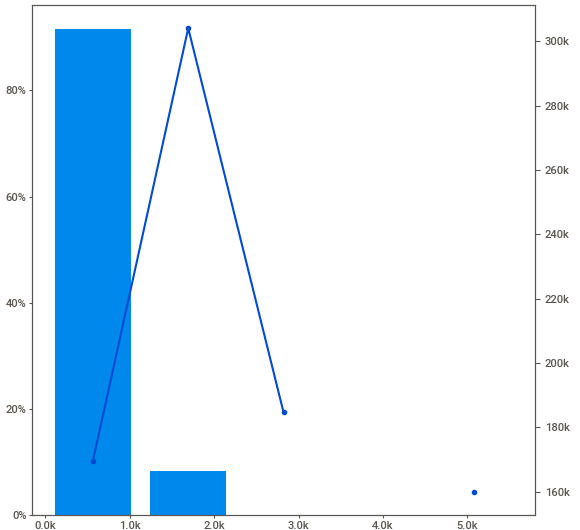
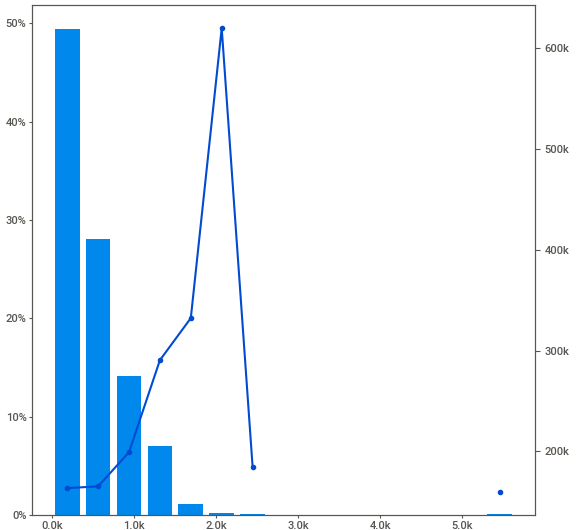
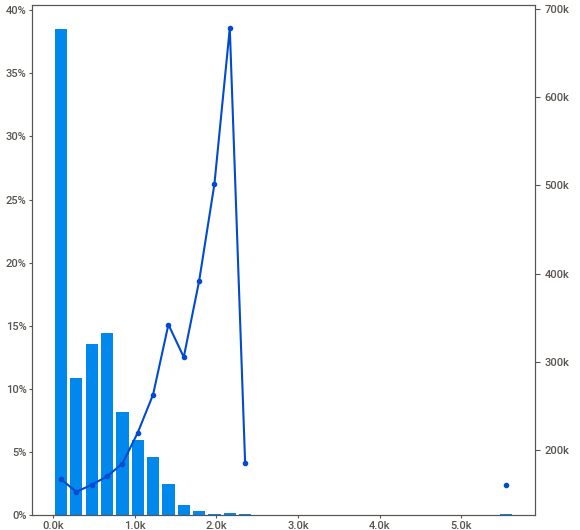
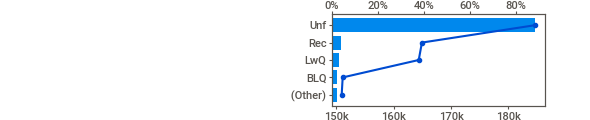
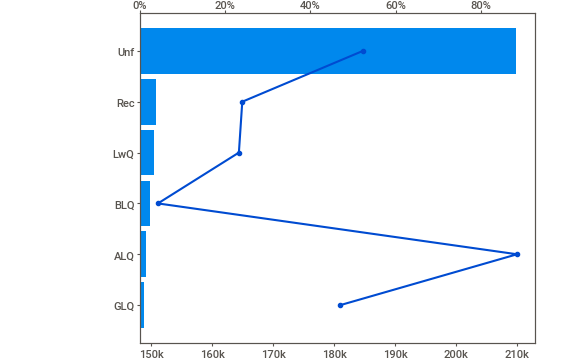
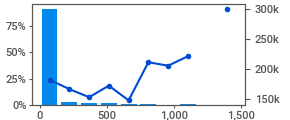
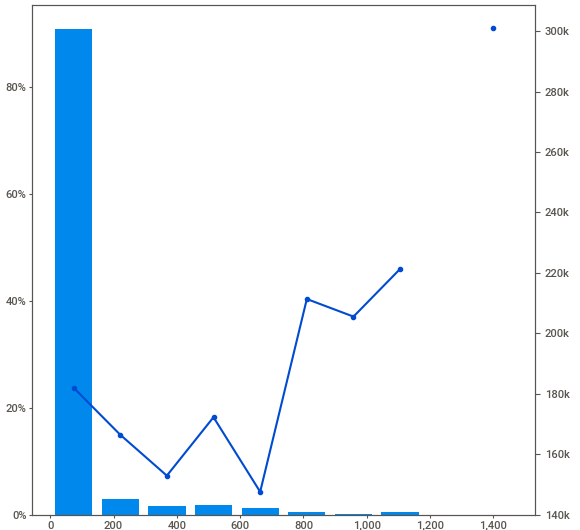
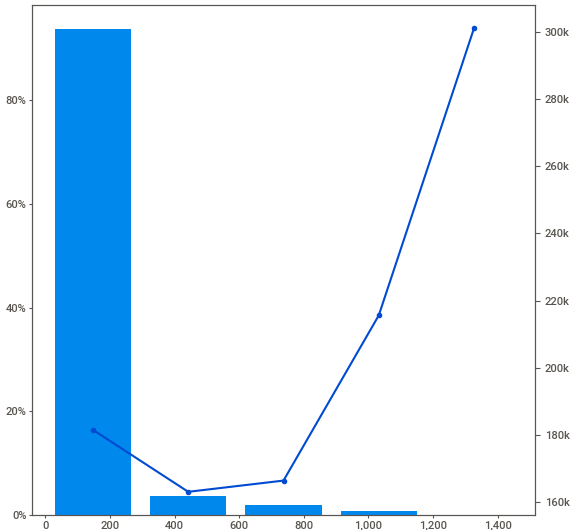
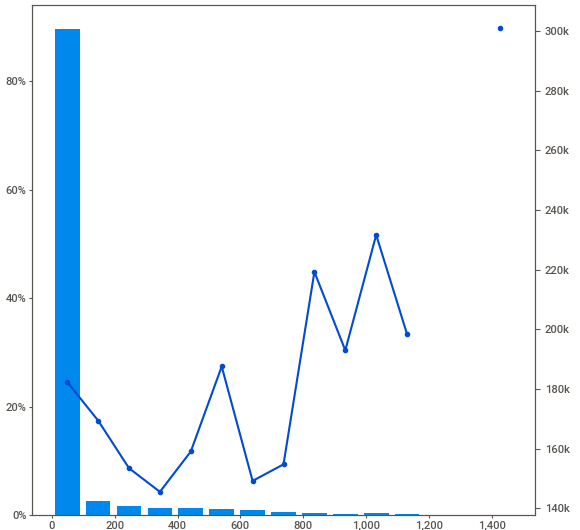
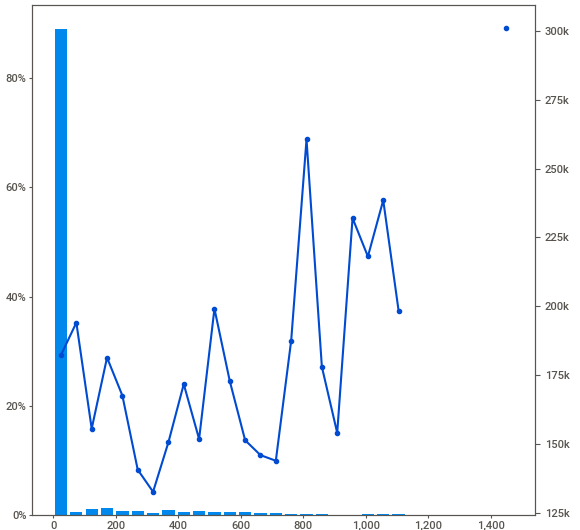
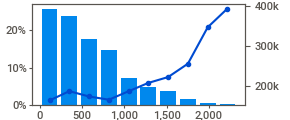
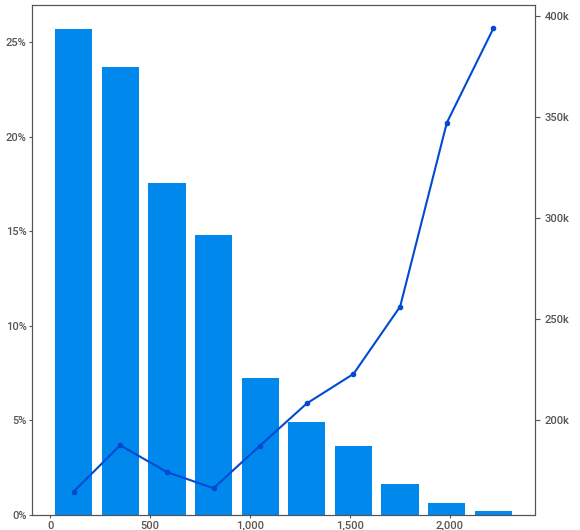
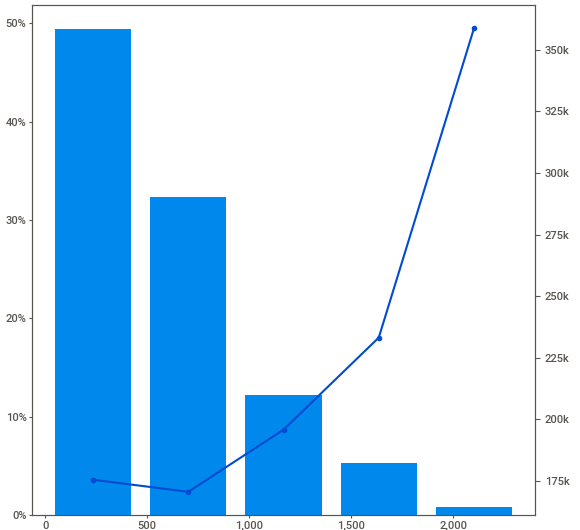
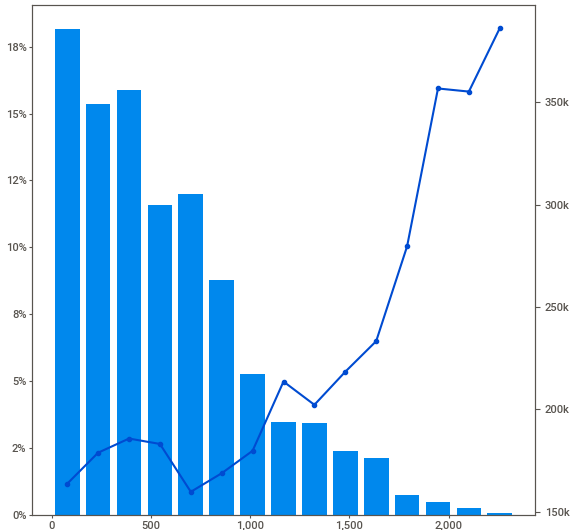
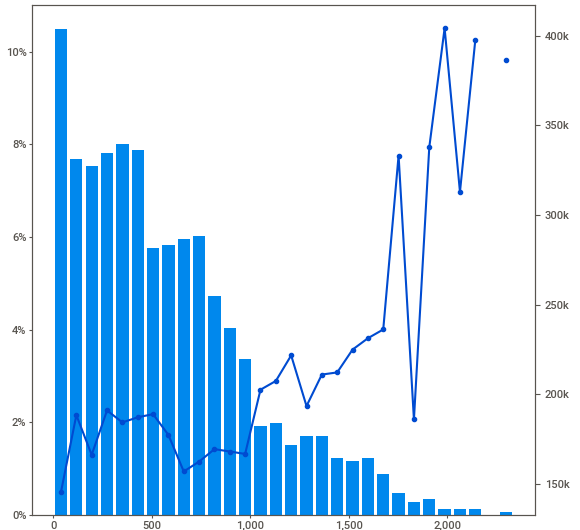
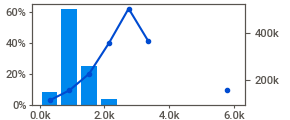
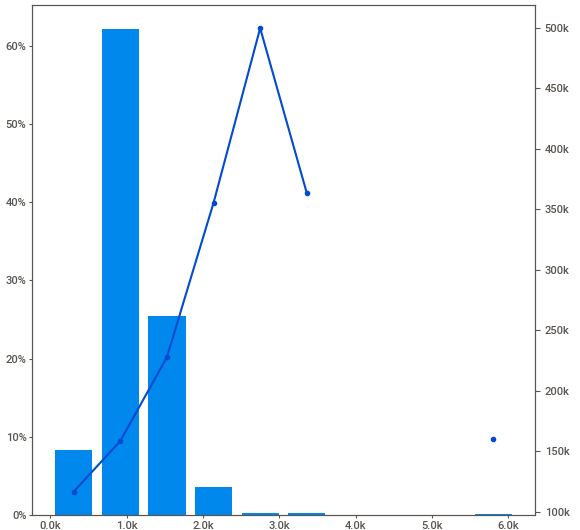
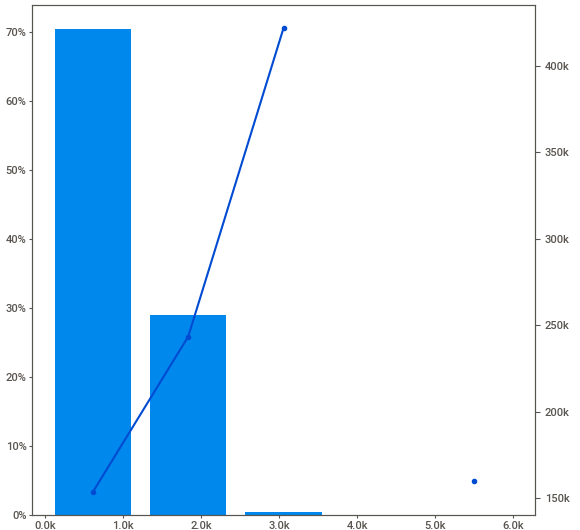
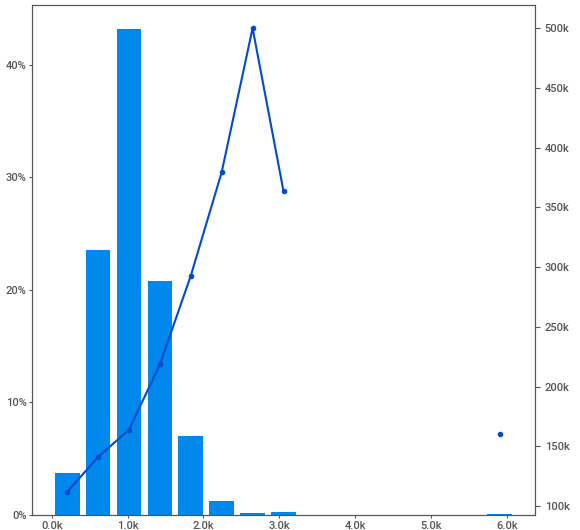
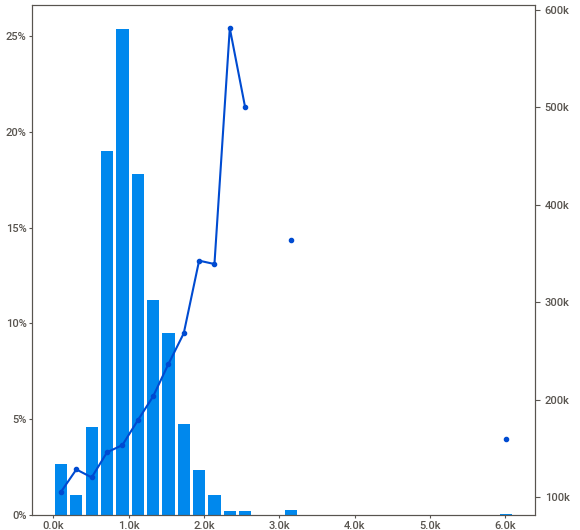
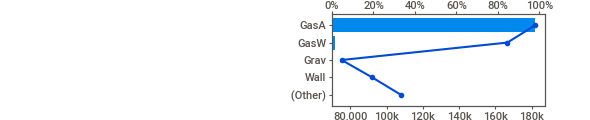
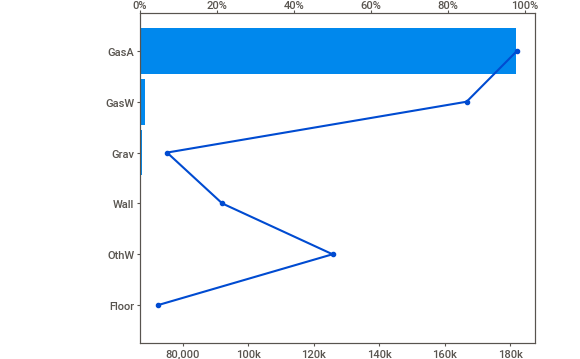
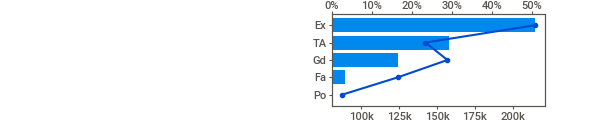
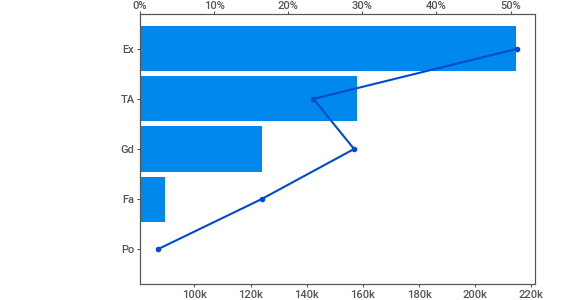
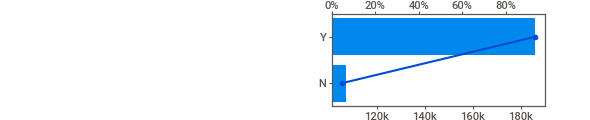
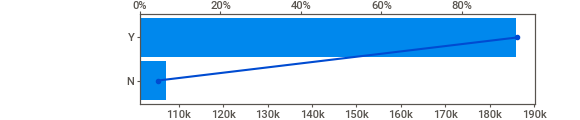
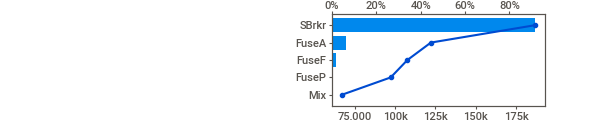
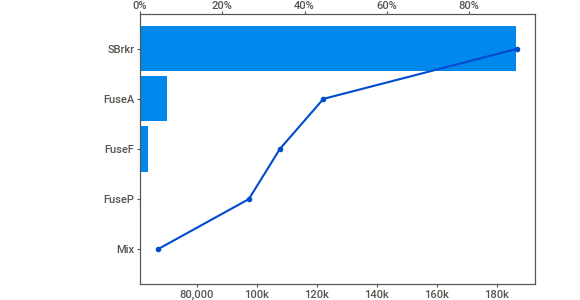
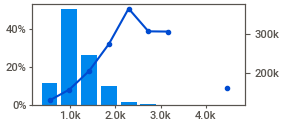
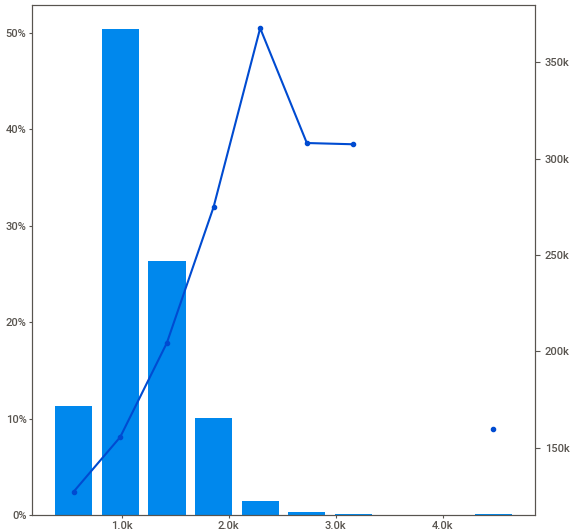
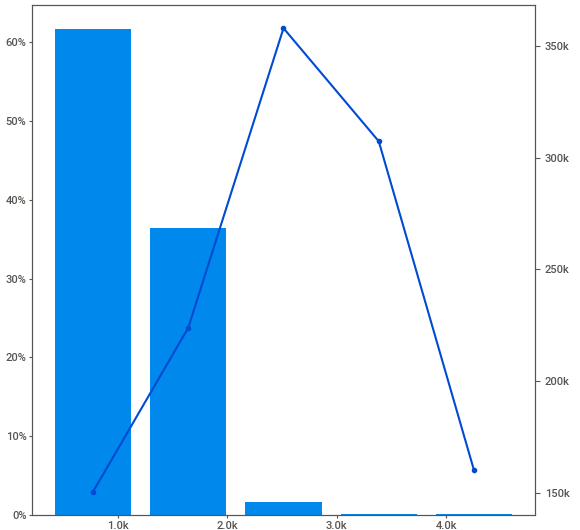
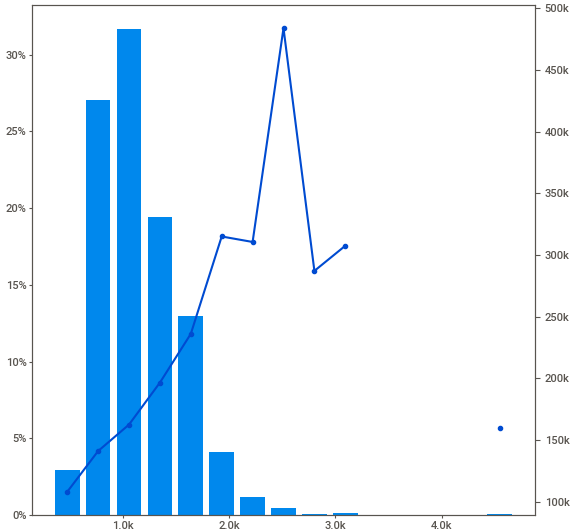
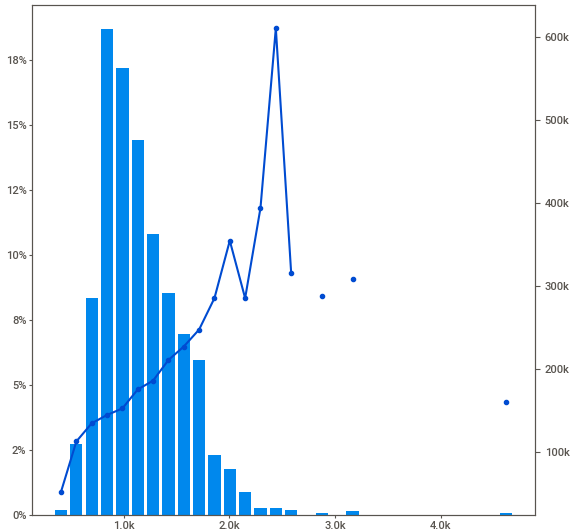
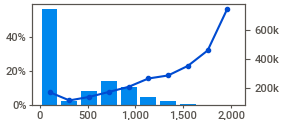
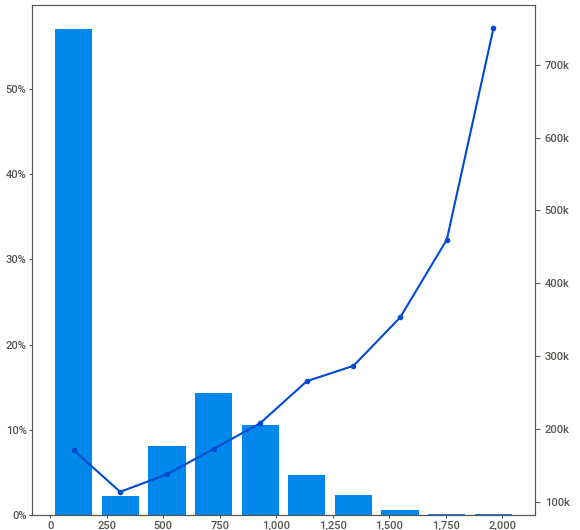
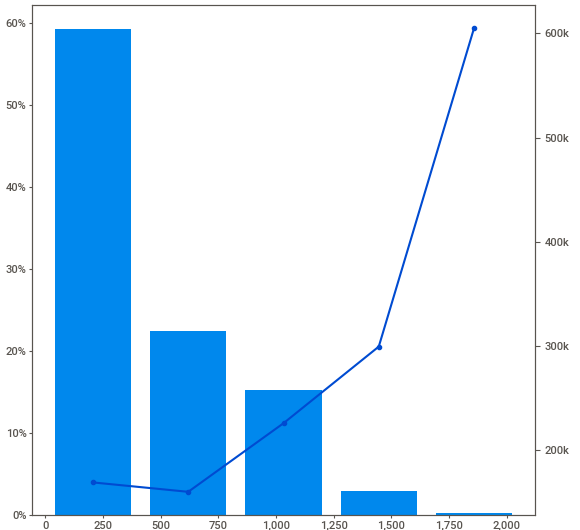
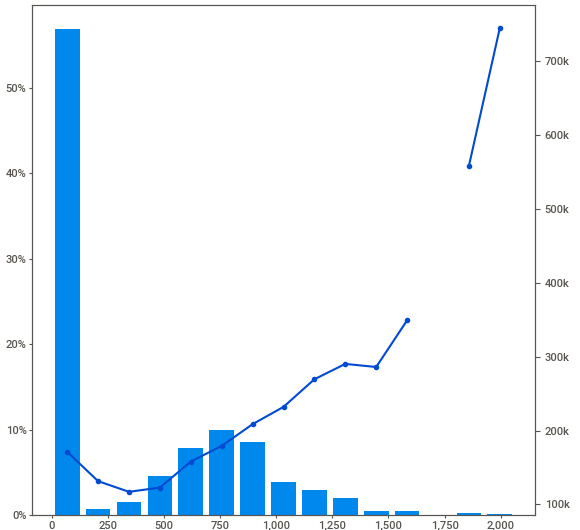
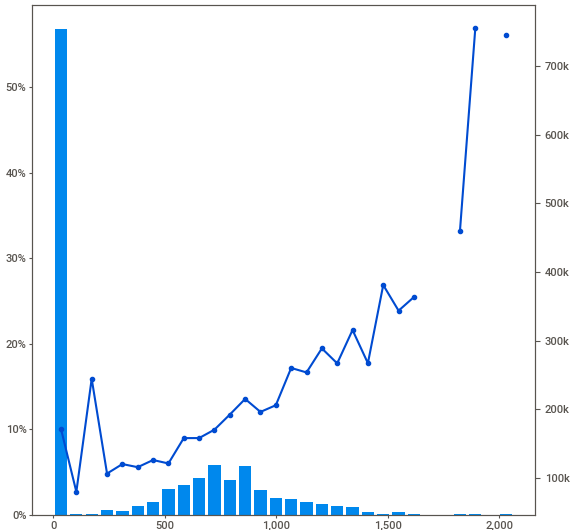
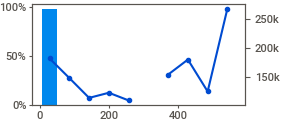
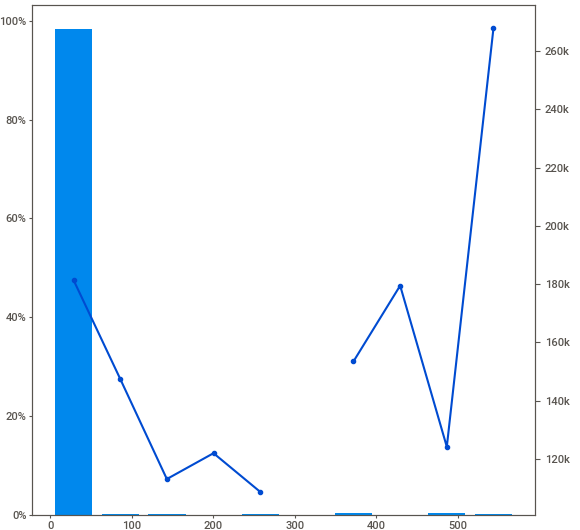
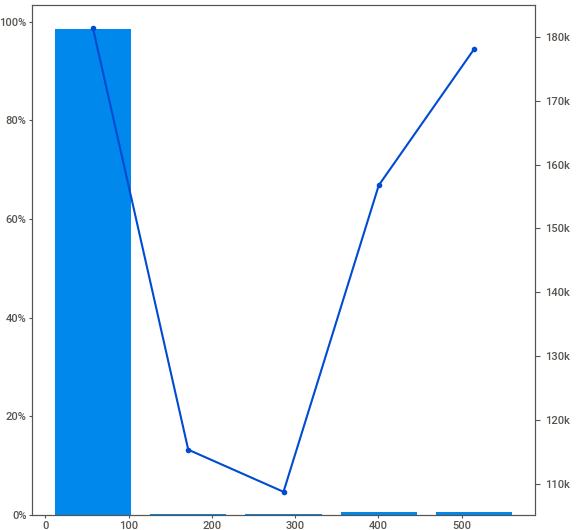
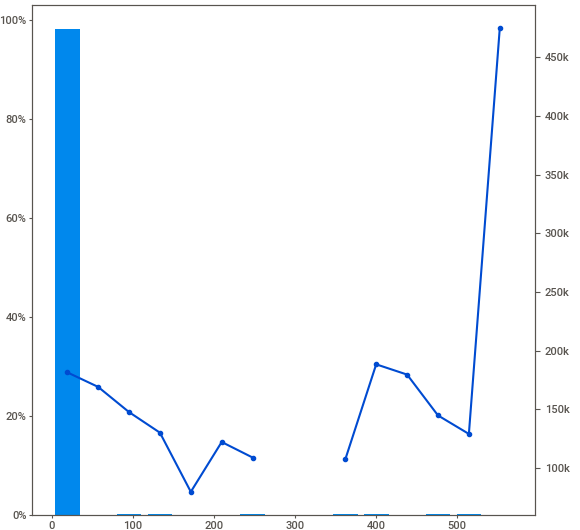
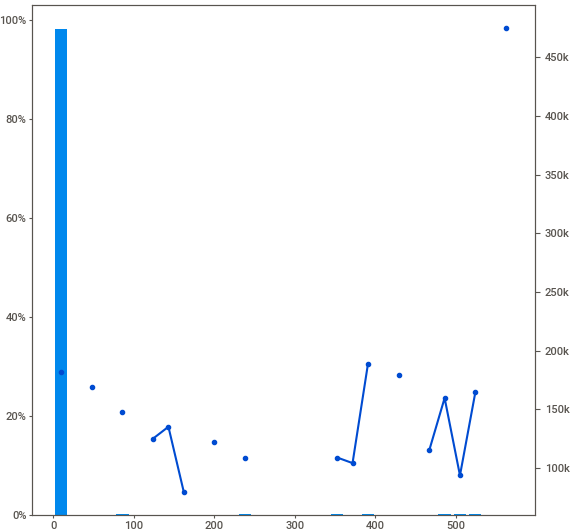
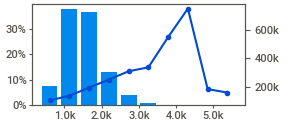
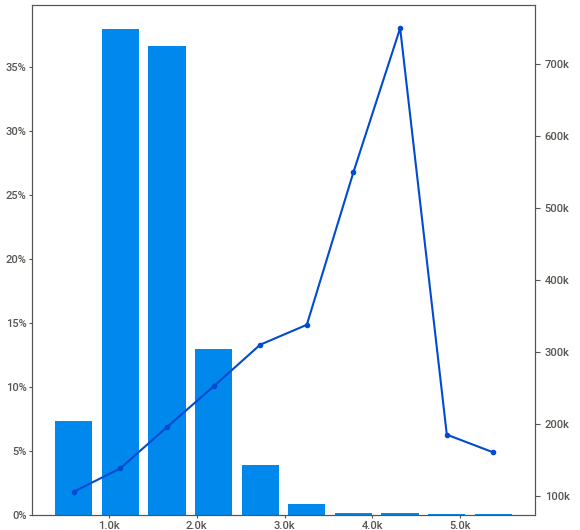
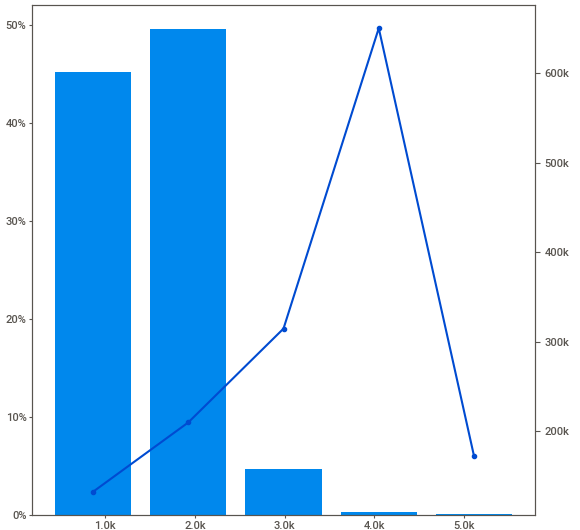
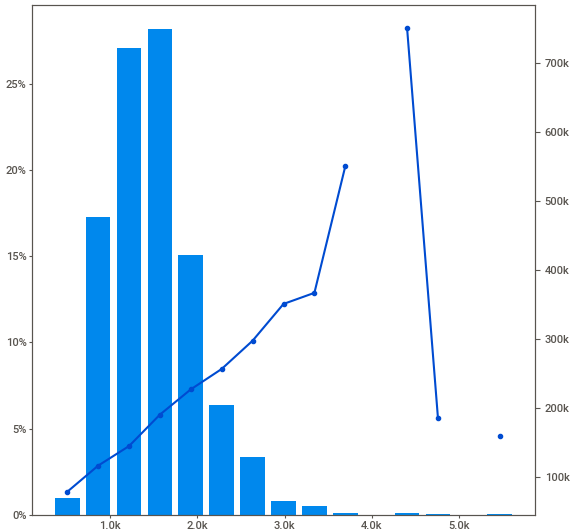
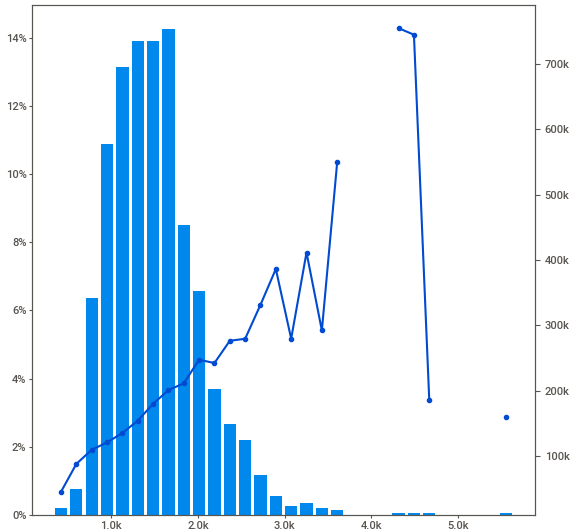
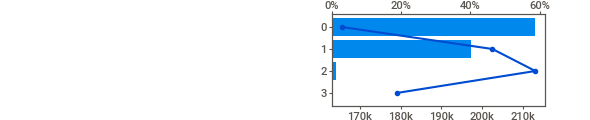
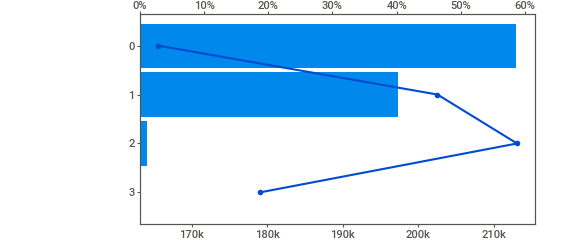
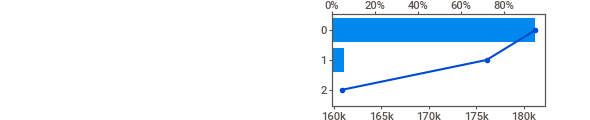
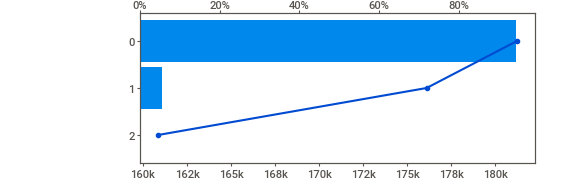
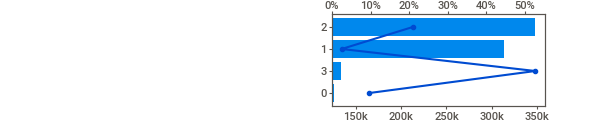
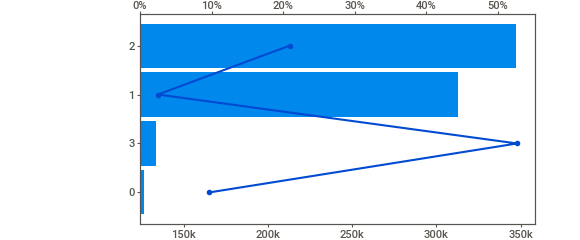
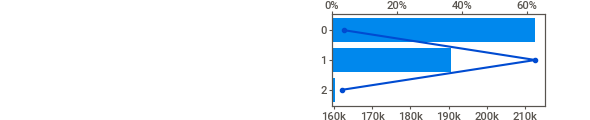
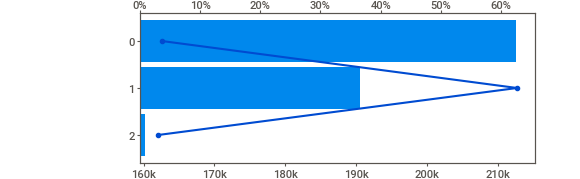
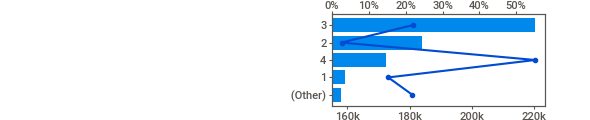
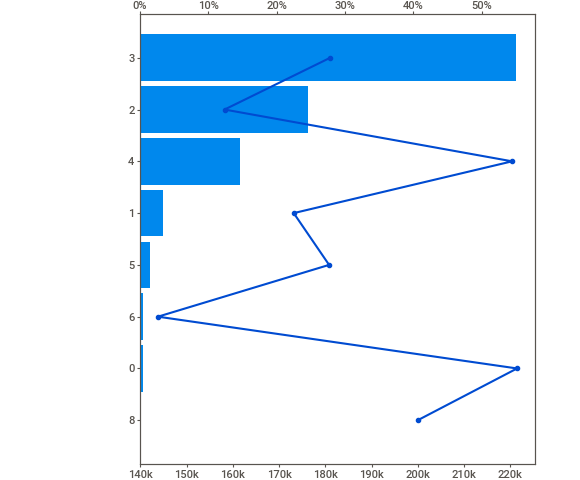
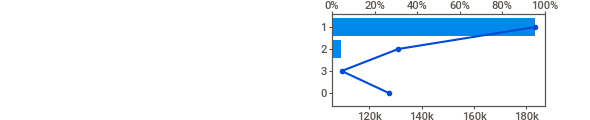
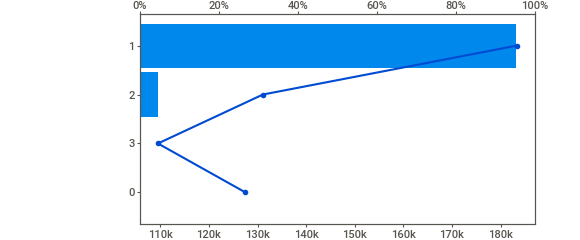
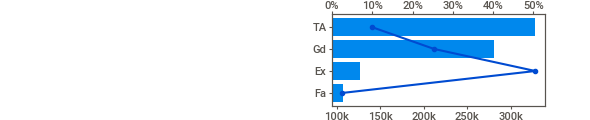
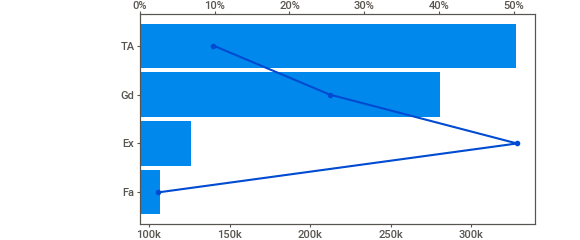
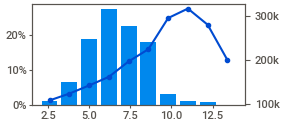
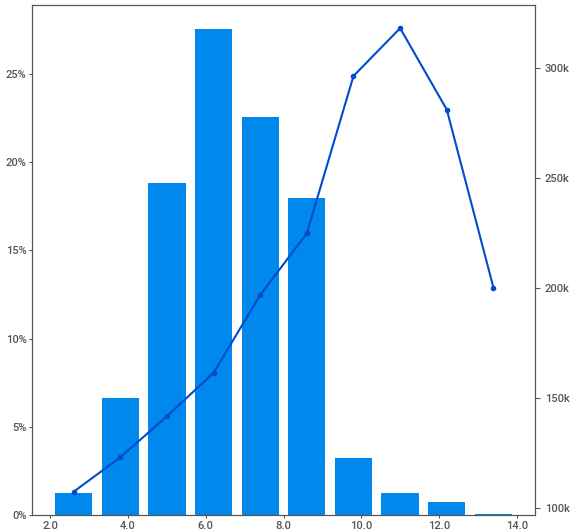
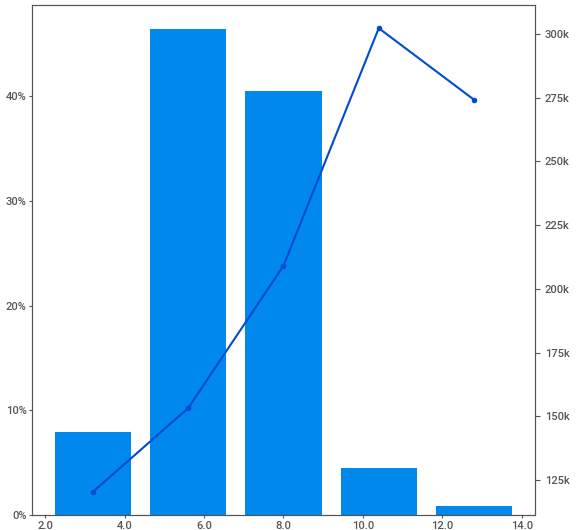
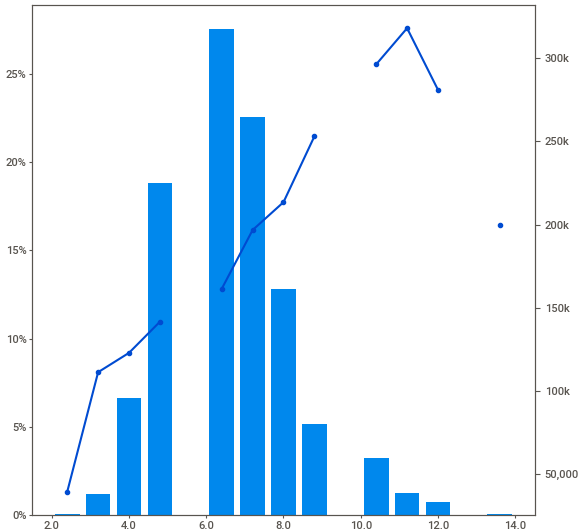
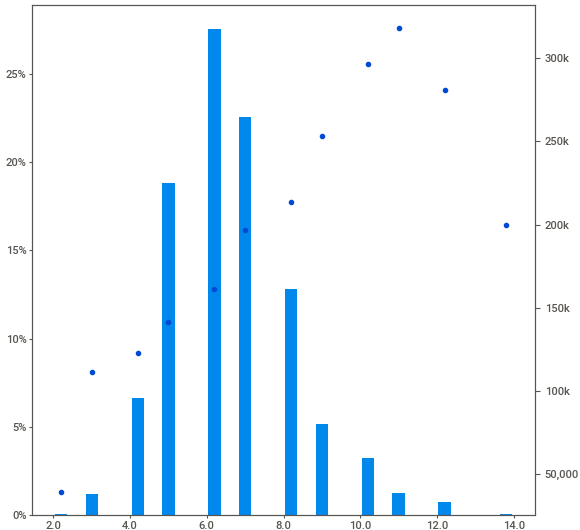
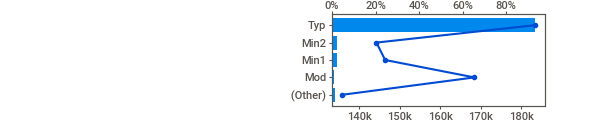
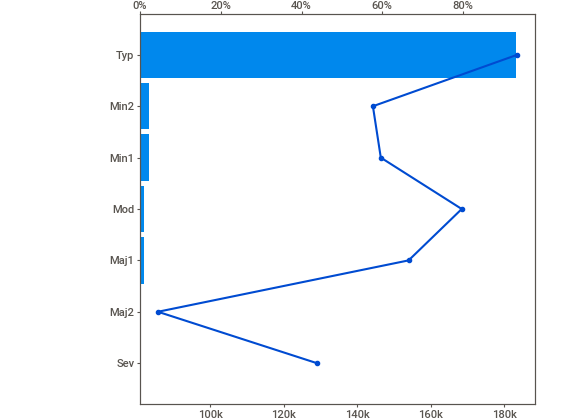
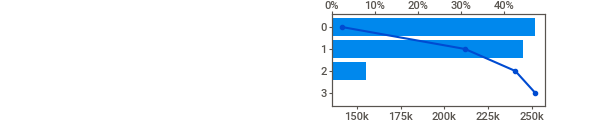
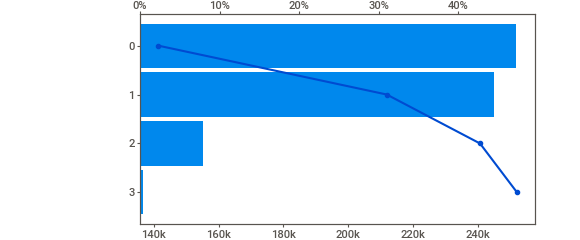
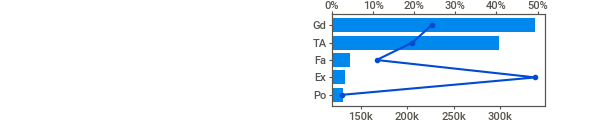
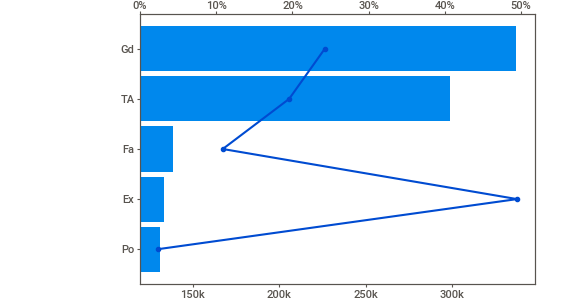
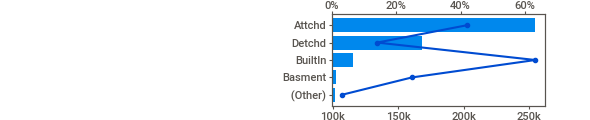
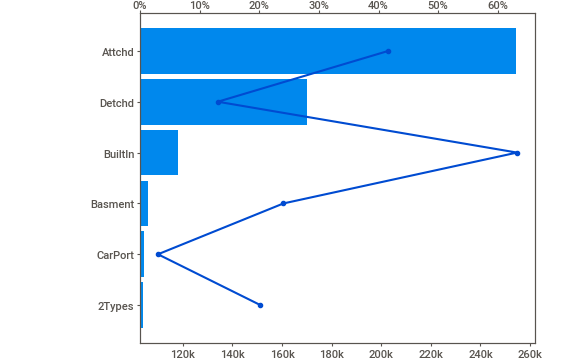
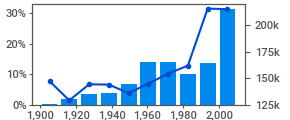
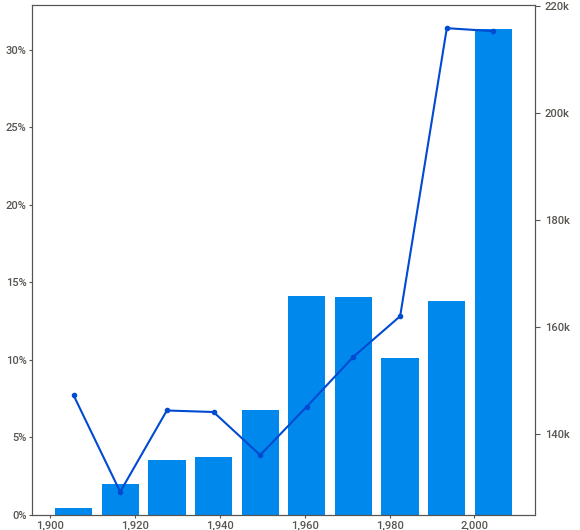
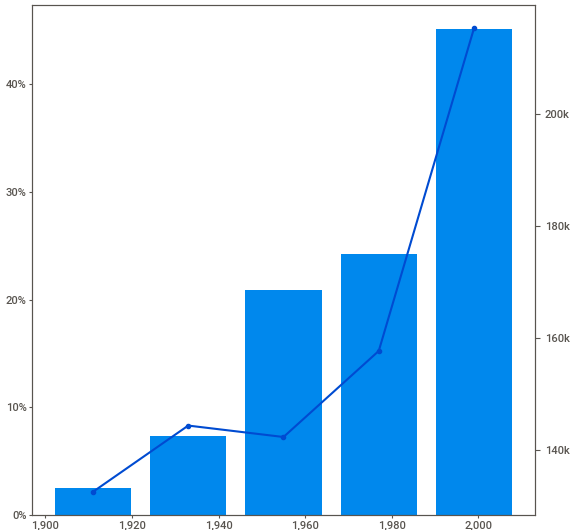
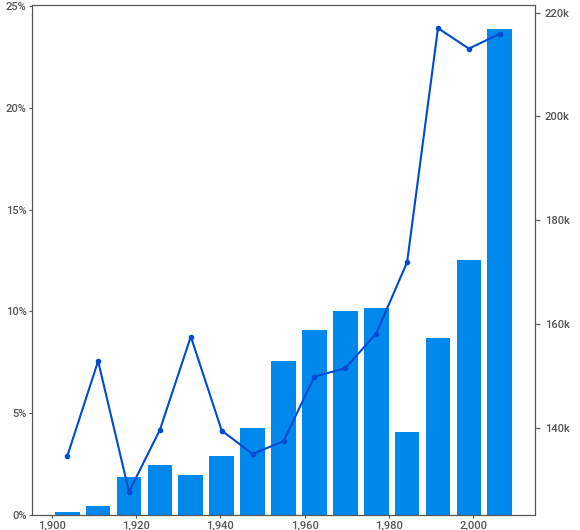
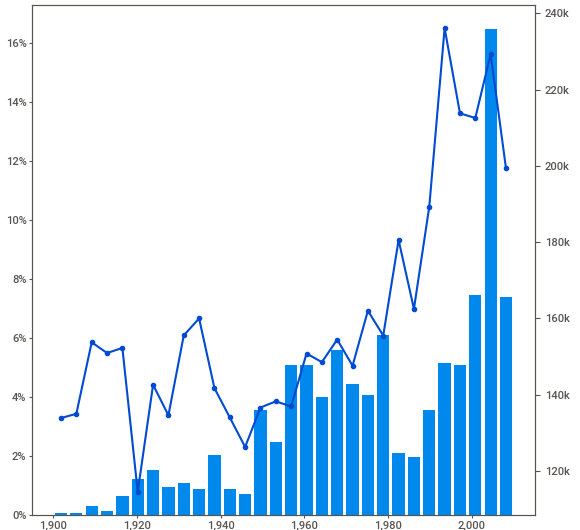
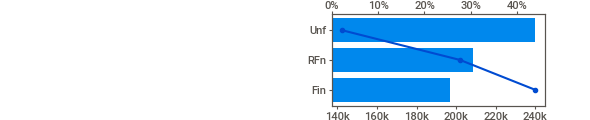
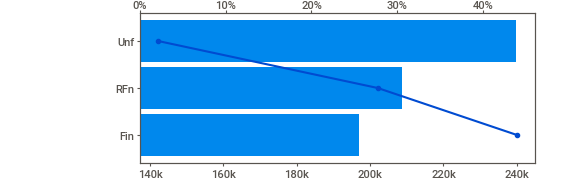
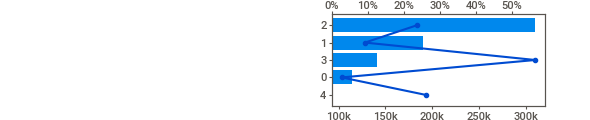
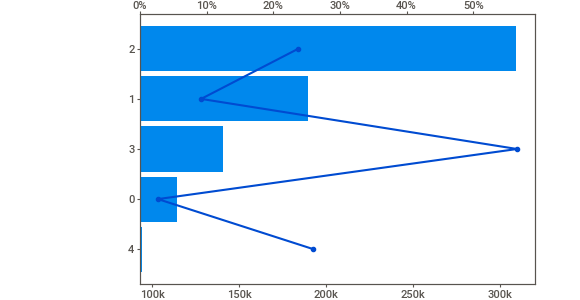
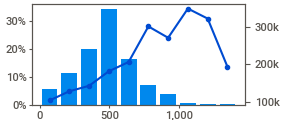
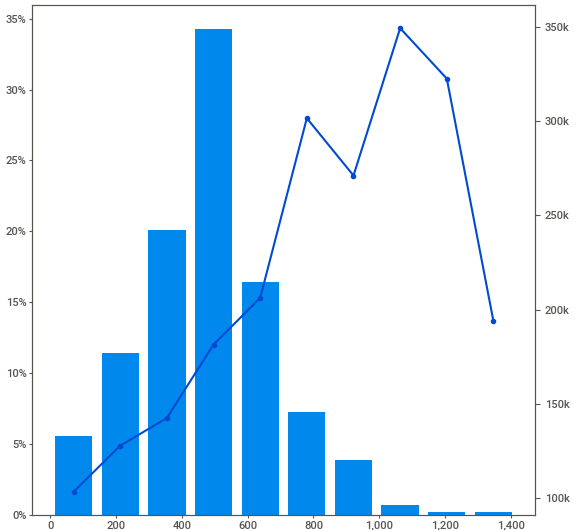
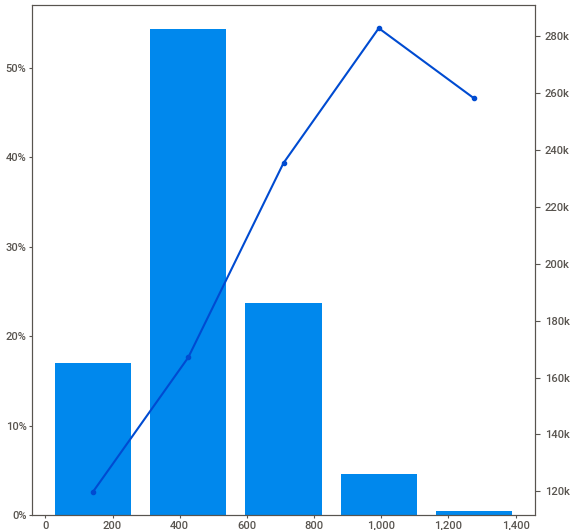
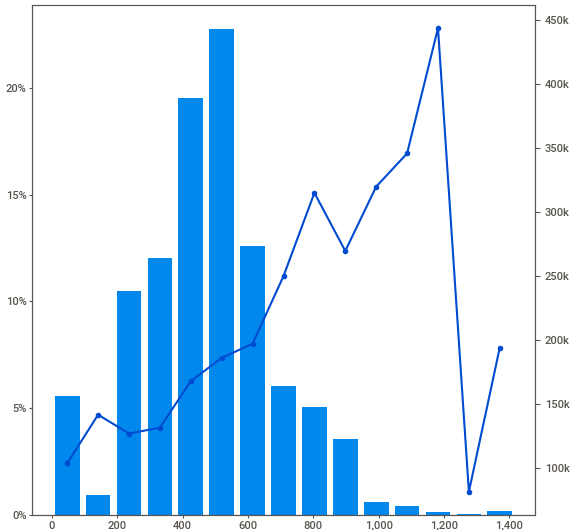
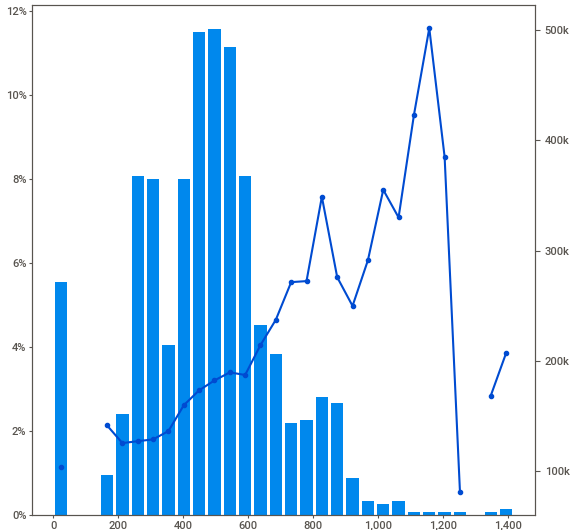
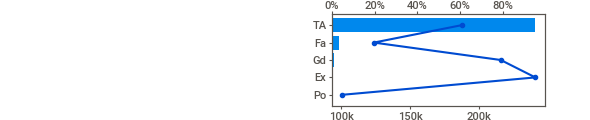
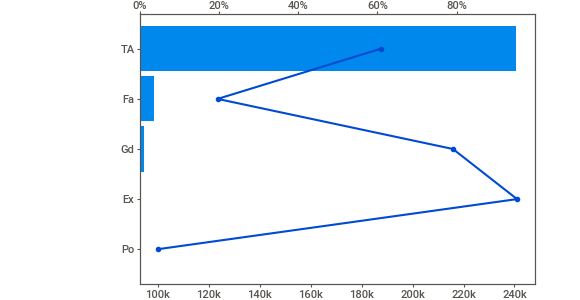
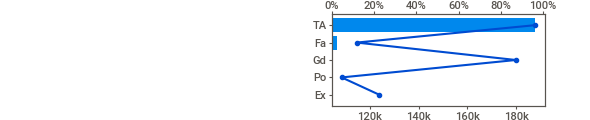
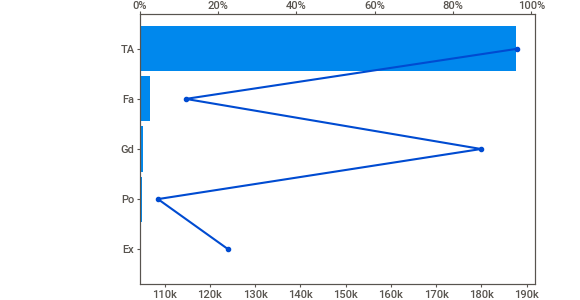
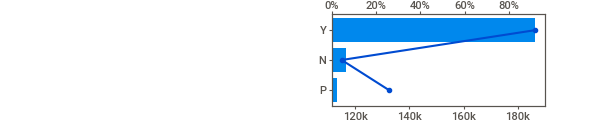
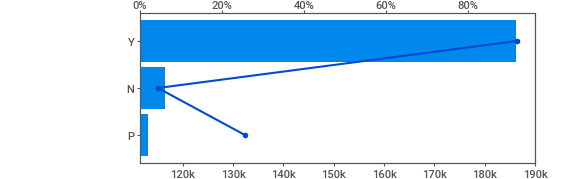
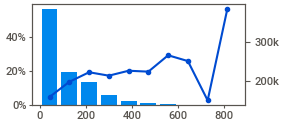
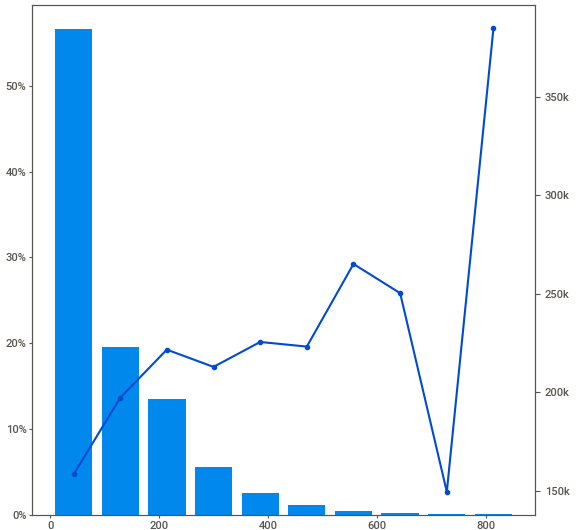
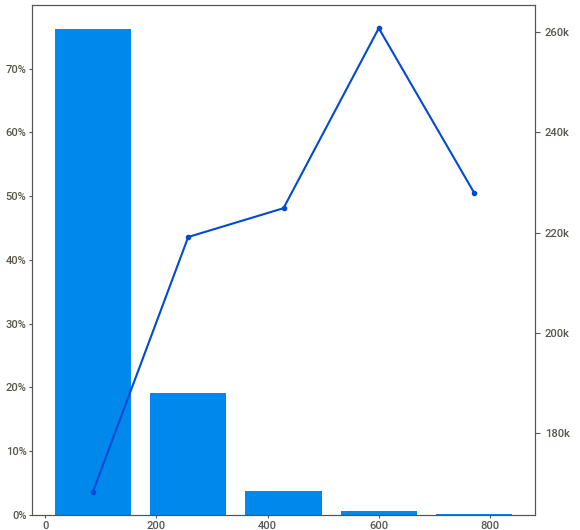
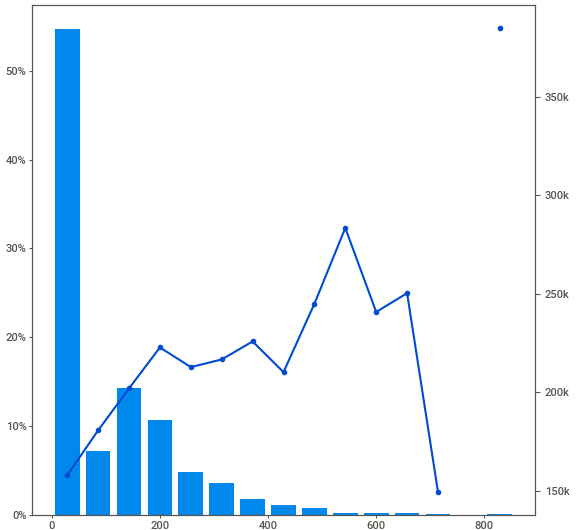
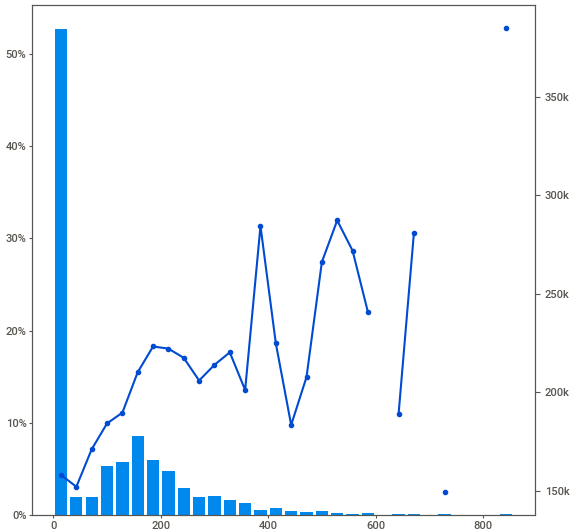
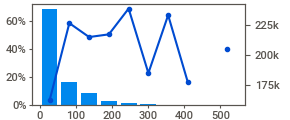
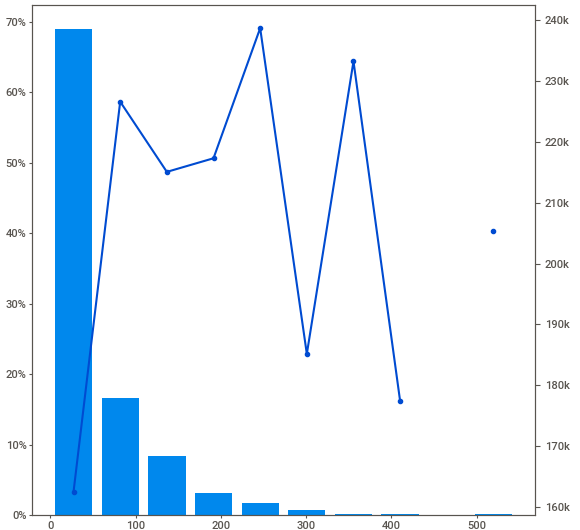
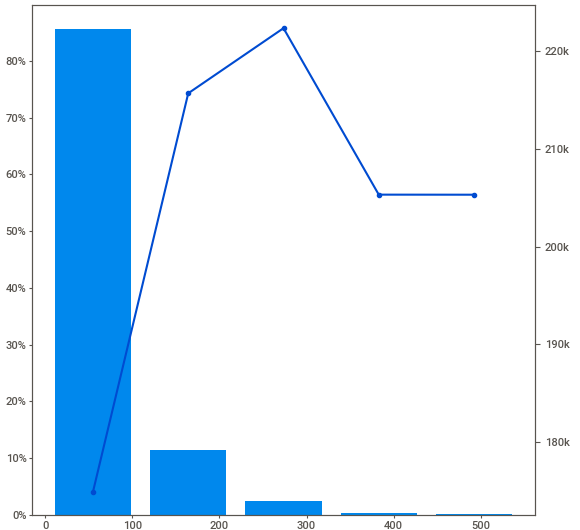
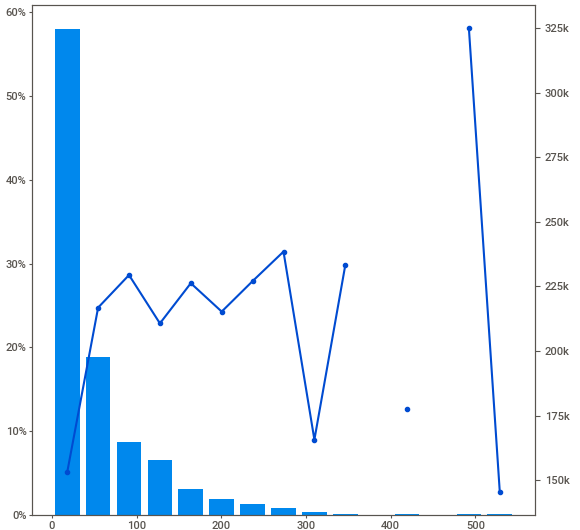
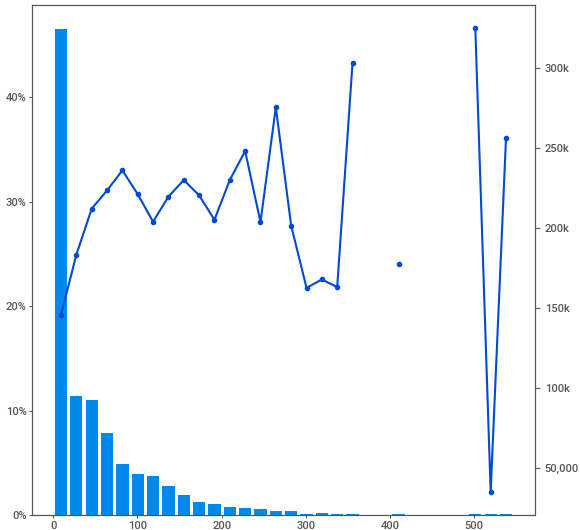
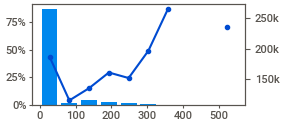
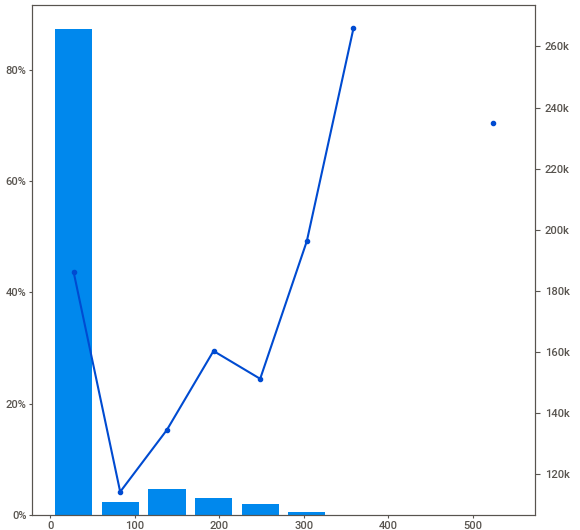
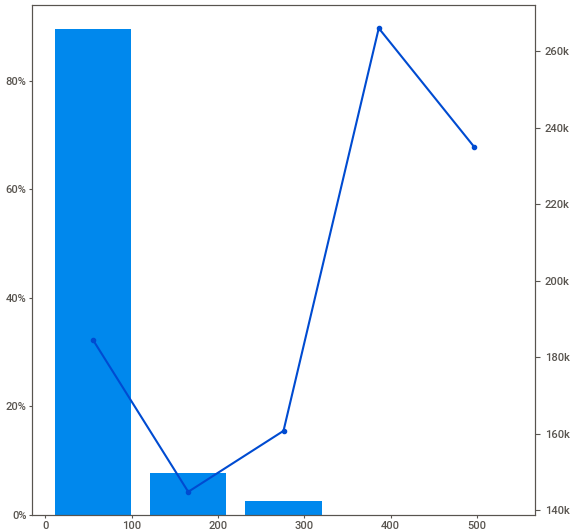
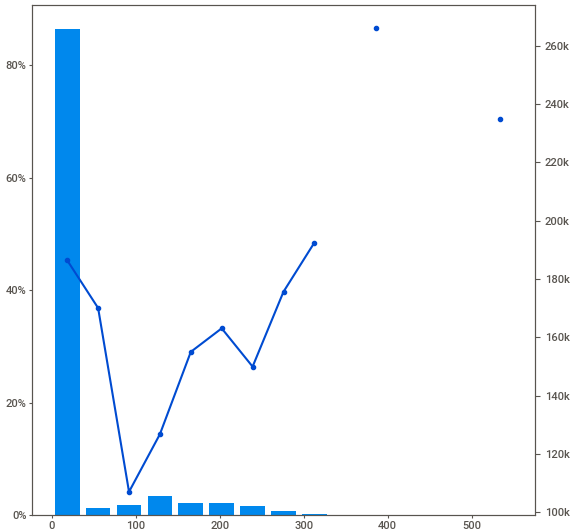
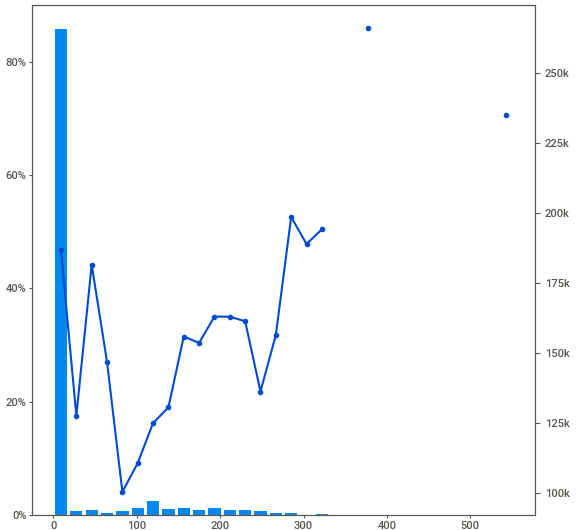
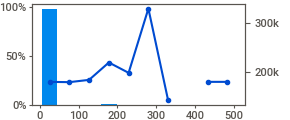
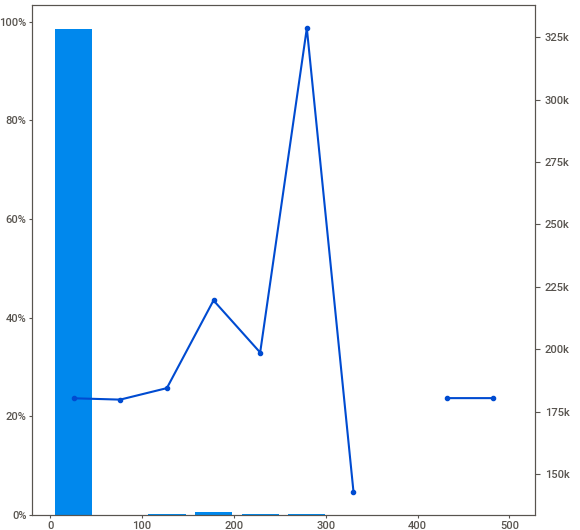
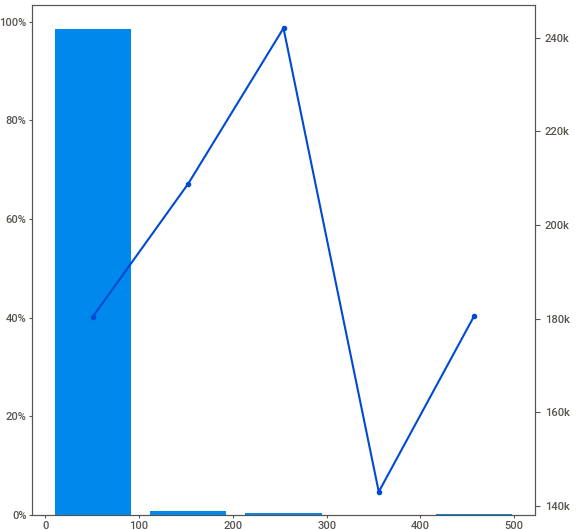
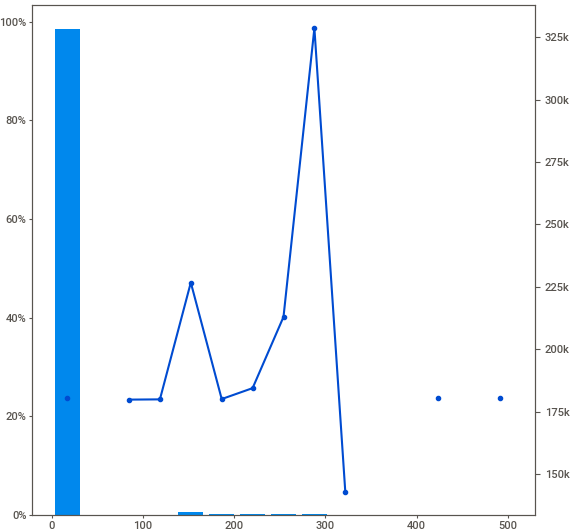
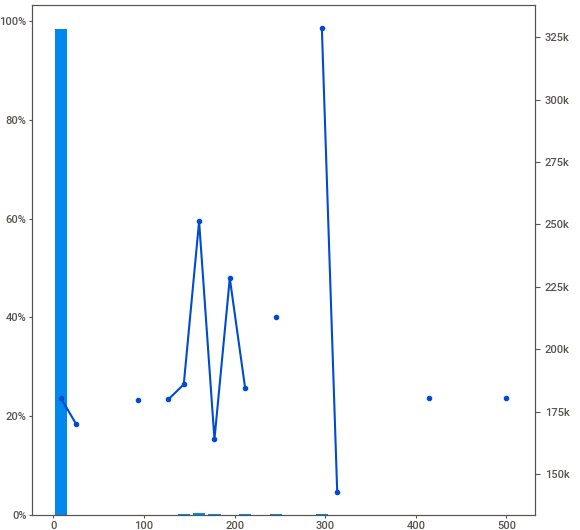
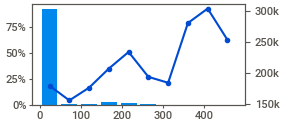
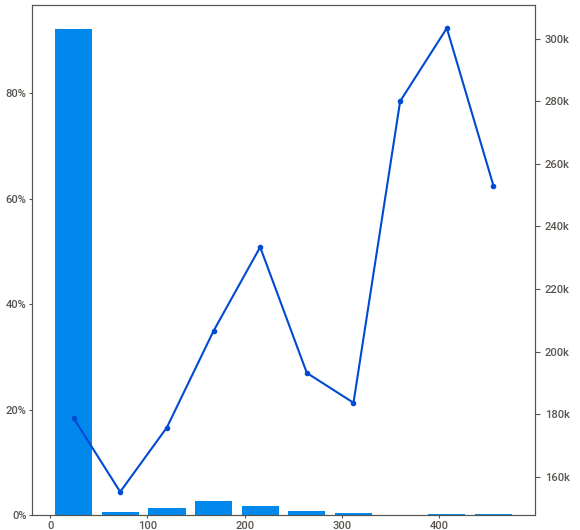
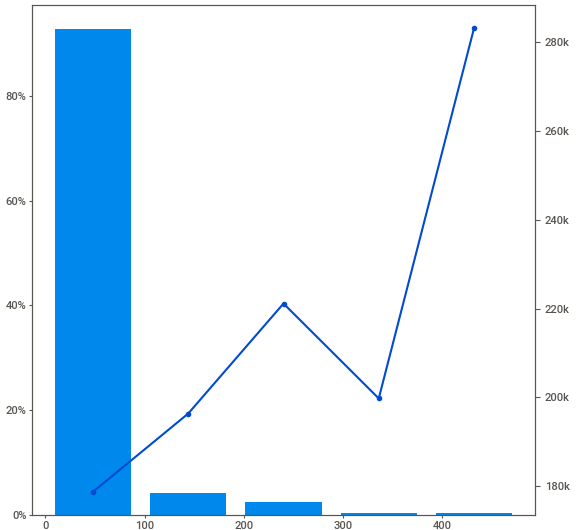
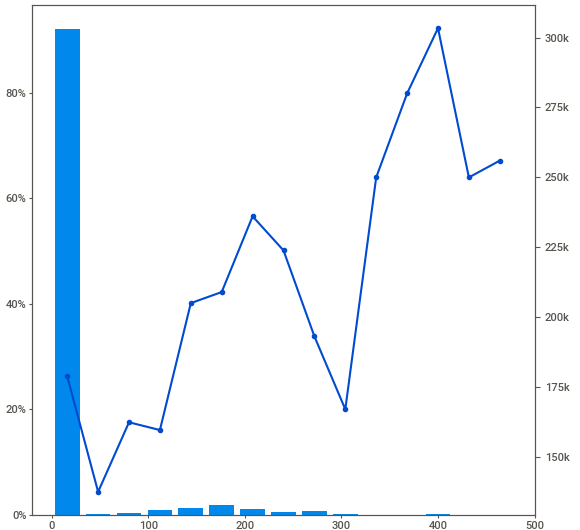
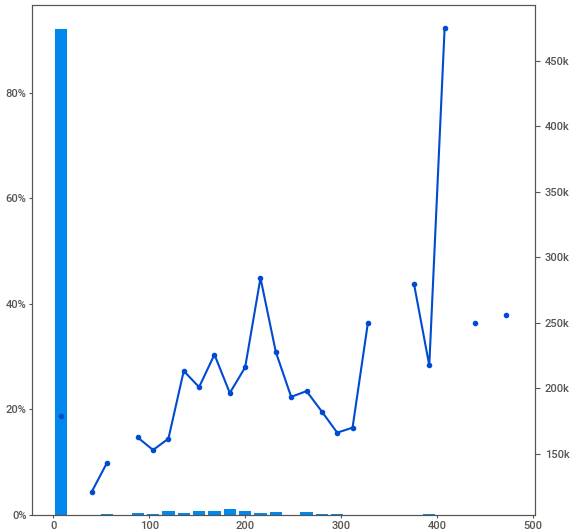
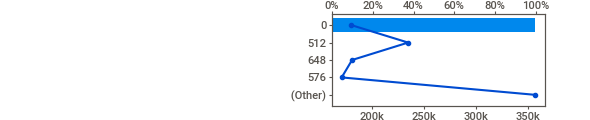
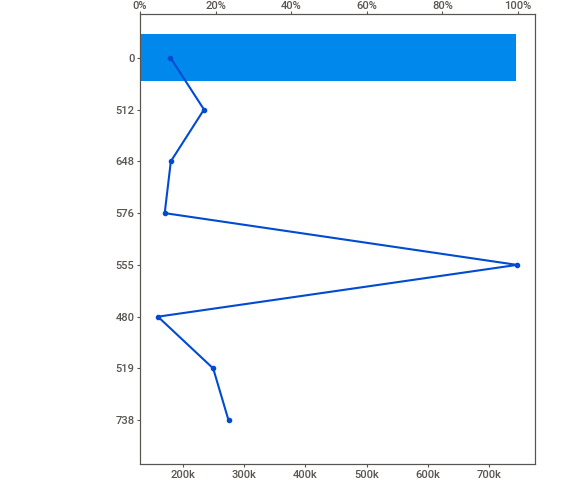
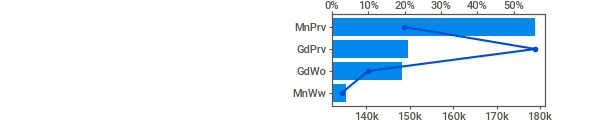
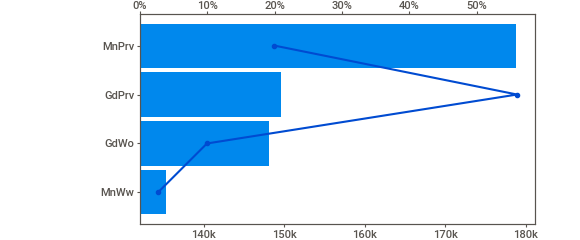
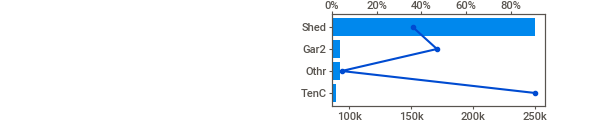
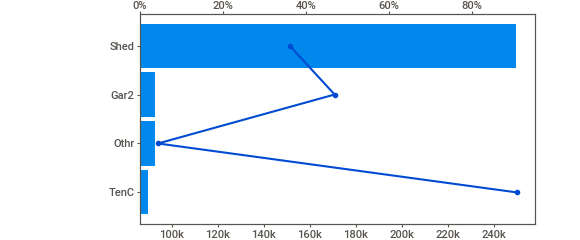
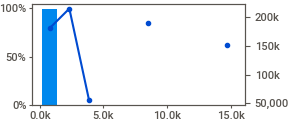
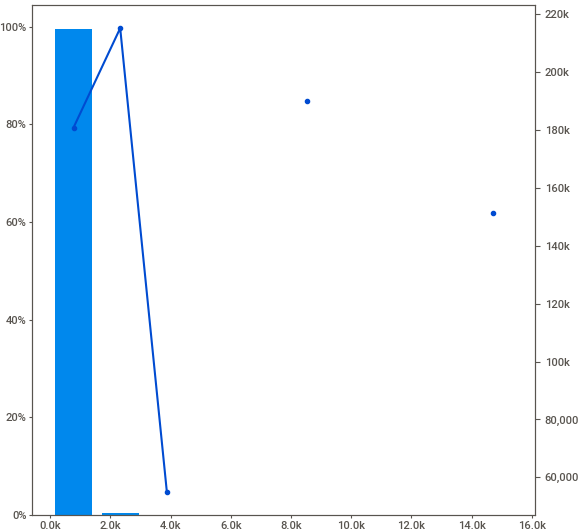
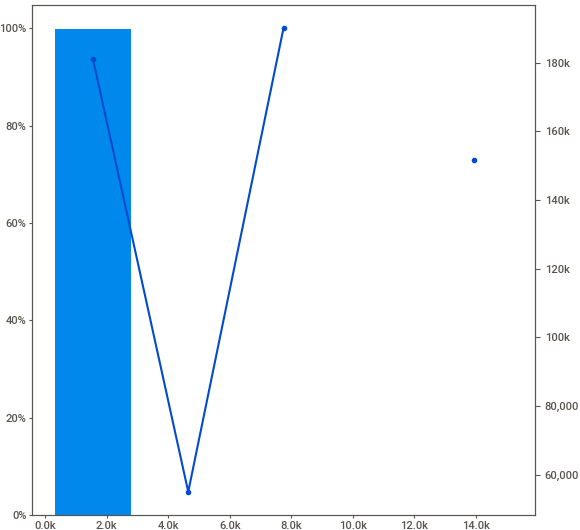
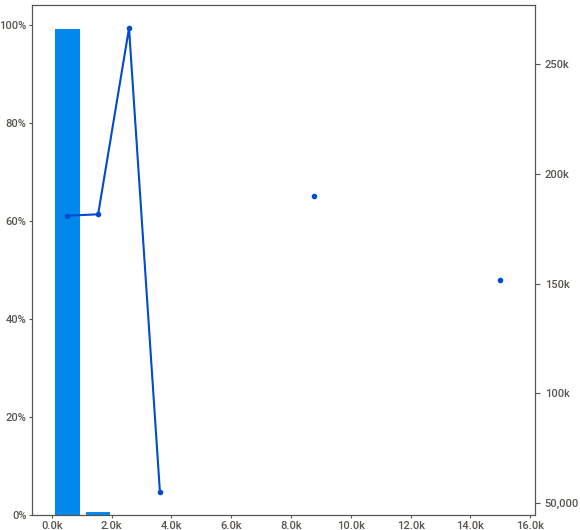
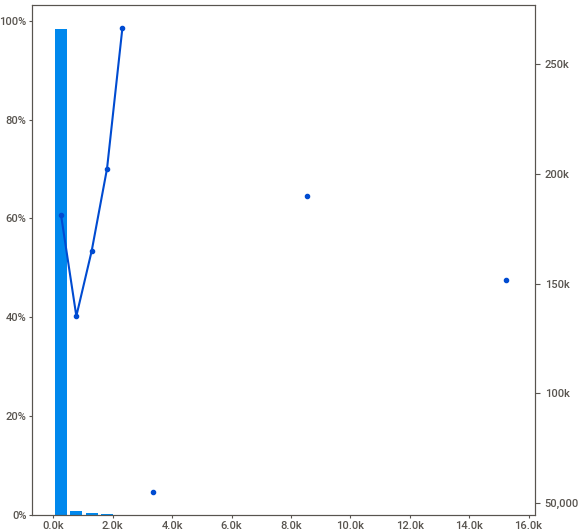
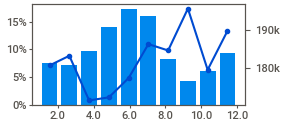
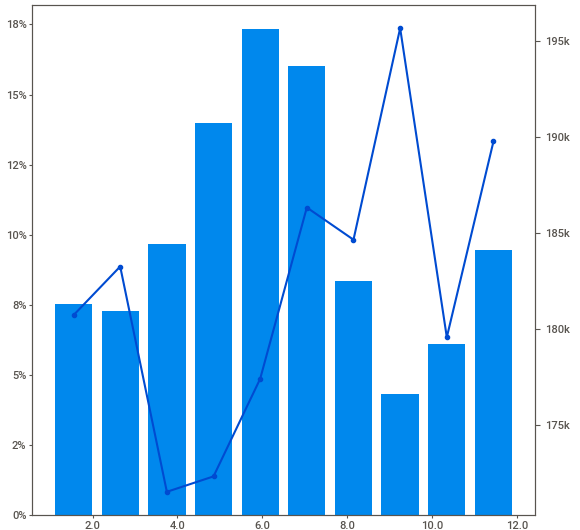
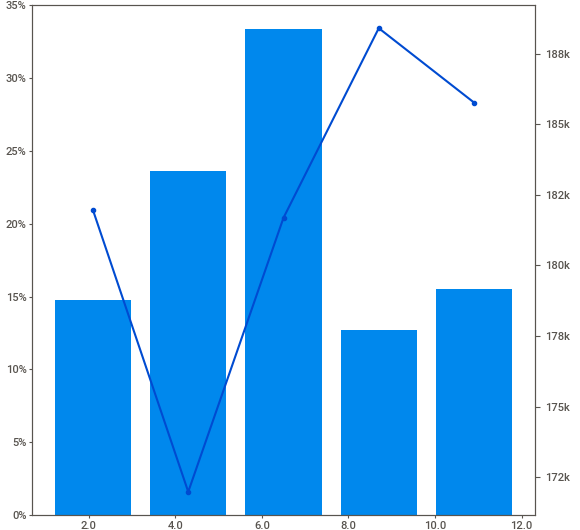
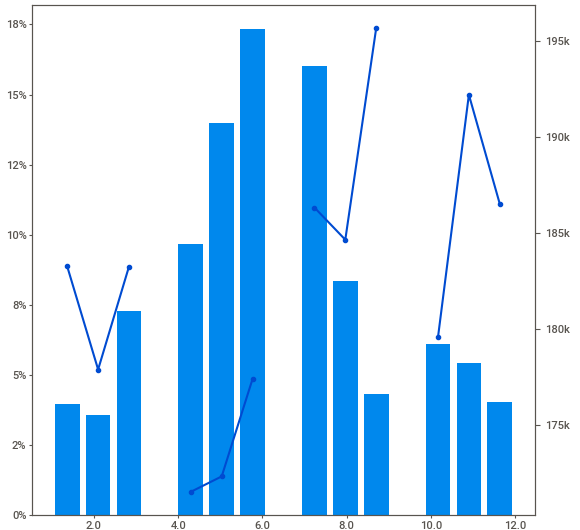
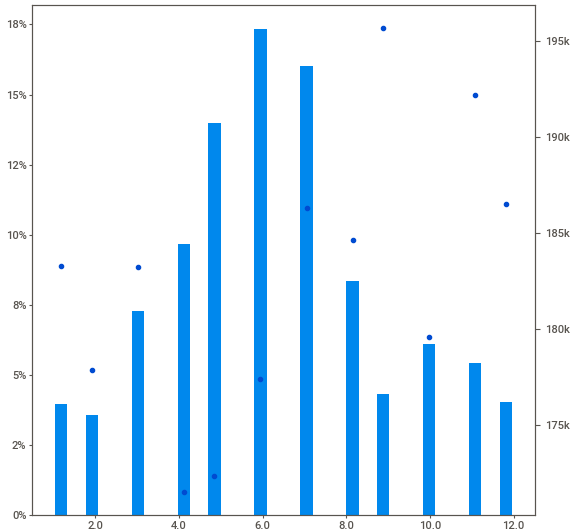
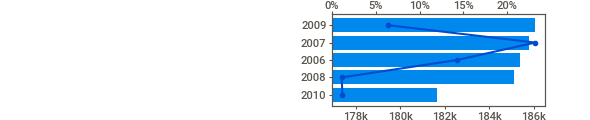
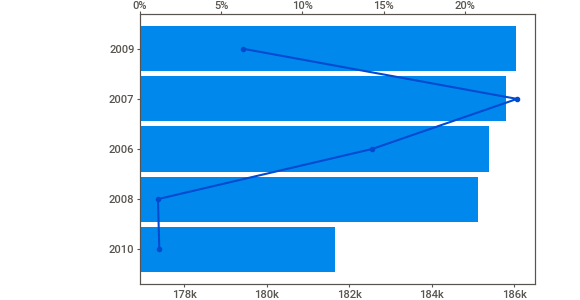
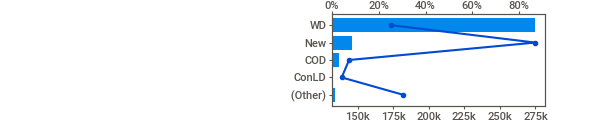
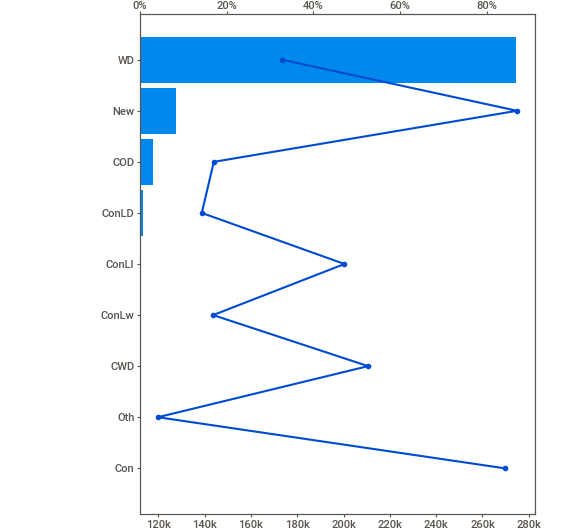
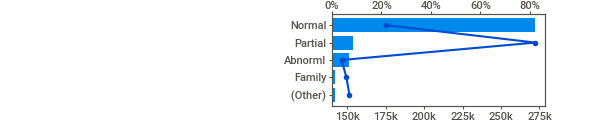
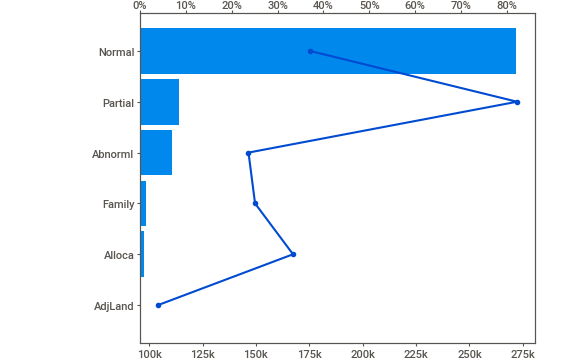
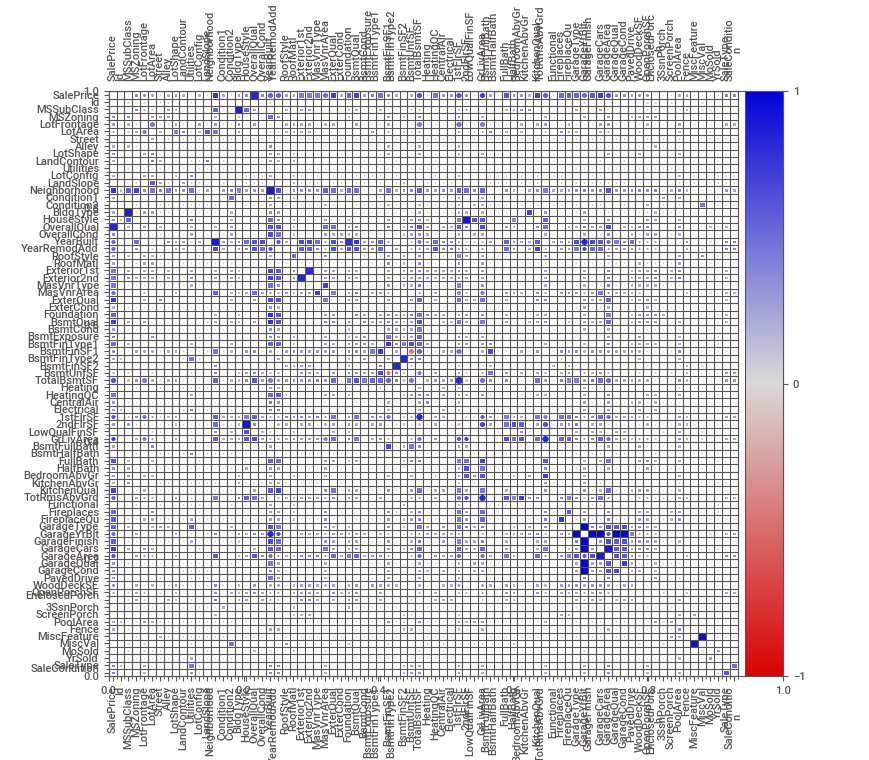
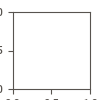

In [7]:
sv.analyze(data, target_feat='SalePrice').show_notebook()

80 признаков - это больше, чем нам необходимо. Воспользуемся матрицей ассоциаций, чтобы выделить из них наименее информативные, и удалим их.

In [8]:
# data = data.loc[:, data.columns.isin(["SalePrice", "Neighborhood", "OverallQual", "YearBuilt", "YearRemodAdd", "Exterior1st", "Exterior2nd", "MasVnrType", "MasVnrArea", "ExterQual", "Foundation", "BsmtQual", "BsmtFinType1", "TotalBsmtSF", "HeatingQC", "1stFlrSF", "GrLivArea", "FullBath", "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea"])]
# Убираем все признаки, кроме наиболее информативных(Неэффективно. Низкие оценки на кросс-валидации)
data = data.drop(["YrSold", "MiscVal", "MiscFeature", "ScreenPorch", "3SsnPorch", "EnclosedPorch", "Functional", "BsmtHalfBath", "LowQualFinSF", "Heating", "BsmtFinSF2", "ExterCond", "LandSlope", "Utilities", "Street", "MSSubClass", "Id"], axis=1)
# Уберём наименее информативные признаки

y = data["SalePrice"] # целевая переменная (target)
X = data.drop(columns=["SalePrice"]) # из пространства признаков выкинули целевую переменную

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

Теперь займёмся препроцессингом. Для ускорения работы с данными сделаем это в пайплайне. Воспользуемся ColumnTransformer, чтобы распределить данные на скейлинг и энкодинг. Попутно заполним отсутствующие значения, у численных данных медианой, у категорий самым часто-встречающимся значением

In [9]:
preprocessor = sklearn.compose.ColumnTransformer([
    ('ohe', Pipeline([
        ('impute', sklearn.impute.SimpleImputer(strategy='most_frequent')),
        ('encode', sklearn.preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), \
     X_train.select_dtypes(exclude='number').columns
    ),
    ('scaler', Pipeline([
        ('impute', sklearn.impute.SimpleImputer(strategy='median')),
        ('scale', sklearn.preprocessing.StandardScaler())
    ]), \
     X_train.select_dtypes(include='number').columns
    )
],
remainder='passthrough'
)

Итого, в рамках разведочного анализа и предобработки, мы:
- Ознакомились с признаками, выявили наличие пропусков и отсутствие ярких аномалий;
- Выявили и удалили малоинформативные признаки при помощи матрицы ассоциаций;
- Провели разделение данных на тренировочную и тестовую выборки
- Подготовили препроцессор для будущих пайплайнов модели, включающий - заполнение пропусков, скейлинг и кодирование признаков.

## Обучение моделей

Теперь приступим к обучению моделей. Выбирая кандидатов постараемся уделить внимание моделям разнообразной сложности. Никогда не знаешь, когда линейная регрессия покажет себя лучше нейросети.  
За представителя сравнительно простой модели возьмём метод опорных векторов с линейным ядром. Обучать будем сразу с подбором гиперпараметров и кросс-валидацией. За метрику возьмём корень среднего квадрата ошибки

In [10]:
svm = Pipeline([
    ('preprocess', preprocessor),
    ('model', sklearn.svm.SVR(kernel='linear'))
])

param_distribution_svm = {
    "model__C": FloatDistribution(1e-3, 1e3, log=True),
    "model__gamma": FloatDistribution(1e-4, 1e1, log=True),
    "model__epsilon": FloatDistribution(0.01, 0.2)
}

svm_cv = optuna.integration.OptunaSearchCV(svm, param_distributions=param_distribution_svm, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)
svm_cv.fit(X_train, y_train)
print('RMSE:',cross_val_score(svm_cv.best_estimator_, X_train, y_train, scoring='neg_root_mean_squared_error').mean()*-1)

C:\Users\m8913\AppData\Local\Temp\ipykernel_2812\584707306.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  svm_cv = optuna.integration.OptunaSearchCV(svm, param_distributions=param_distribution_svm, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)
[I 2025-03-27 11:54:47,738] A new study created in memory with name: no-name-1aed3424-c180-406b-aae1-e98abea44bbf
[I 2025-03-27 11:54:48,146] Trial 0 finished with value: -81888.26082198271 and parameters: {'model__C': 0.003585583615585772, 'model__gamma': 1.0476834405905207, 'model__epsilon': 0.06961979194105183}. Best is trial 0 with value: -81888.26082198271.
[I 2025-03-27 11:54:48,534] Trial 1 finished with value: -81802.6808220816 and parameters: {'model__C': 0.024412890980453777, 'model__gamma': 0.001593717567647103, 'model__epsilon': 0.08915874944020485}. Best is trial 1 with value: -81802.6808220816.
[I 2025-03-27 11:54:4

RMSE: 37164.61725644615


Этот результат не предел совершенства, поэтому мы попробуем его улучшить.

Воспользуемся более сложной моделью - лёгким градиентным бустингом. Точно так-же подберём гиперпараметры и проверим качество лучшей модели на кросс-валидации.

In [11]:
lgbm = Pipeline([
    ('preprocess', preprocessor),
    ('model', lightgbm.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, objective='poisson', boosting_type='gbdt'))
])

param_distribution_lgbm = {
    'model__num_leaves': IntDistribution(low=20, high=150, step=1),
    'model__max_depth': IntDistribution(low=3, high=15, step=1),
    'model__learning_rate': FloatDistribution(low=0.01, high=0.3, log=False),
    'model__n_estimators': IntDistribution(low=50, high=500, step=50),
    'model__min_child_samples': IntDistribution(low=5, high=100, step=5),
    'model__colsample_bytree': FloatDistribution(low=0.6, high=1.0),
    'model__reg_alpha': FloatDistribution(low=0, high=1),
    'model__reg_lambda': FloatDistribution(low=0, high=1)
}

lgbm_cv = optuna.integration.OptunaSearchCV(lgbm, param_distributions=param_distribution_lgbm, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)

lgbm_cv.fit(X_train, y_train)
print('RMSE:', cross_val_score(lgbm_cv.best_estimator_, X_train, y_train, scoring='neg_root_mean_squared_error').mean()*-1)

C:\Users\m8913\AppData\Local\Temp\ipykernel_2812\2730049852.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgbm_cv = optuna.integration.OptunaSearchCV(lgbm, param_distributions=param_distribution_lgbm, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)
[I 2025-03-27 11:54:52,208] A new study created in memory with name: no-name-d6b4a832-6f45-4e2e-945e-7dd9a41f4e17
[I 2025-03-27 11:54:53,833] Trial 0 finished with value: -28587.832084951377 and parameters: {'model__num_leaves': 32, 'model__max_depth': 13, 'model__learning_rate': 0.10099862980476332, 'model__n_estimators': 150, 'model__min_child_samples': 25, 'model__colsample_bytree': 0.7666499988214839, 'model__reg_alpha': 0.7647446160554672, 'model__reg_lambda': 0.8391429575464384}. Best is trial 0 with value: -28587.832084951377.
[I 2025-03-27 11:54:54,503] Trial 1 finished with value: -29219.8913615595 and parameters: {'

RMSE: 27320.849053227634


Значительно лучше, но есть куда совершенствоваться.

Следующая модель - случайный лес.

In [12]:
forest = Pipeline([
    ('preprocess', preprocessor),
    ('model', sklearn.ensemble.RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_distribution_forest = {
    "model__n_estimators": IntDistribution(50, 500, step=50),
    "model__max_depth": IntDistribution(3, 15),
    "model__min_samples_split": IntDistribution(2, 20),
    "model__min_samples_leaf": IntDistribution(1, 10),
    "model__criterion": CategoricalDistribution(["squared_error", "absolute_error", "friedman_mse"]),
    "model__max_features": CategoricalDistribution(["sqrt", "log2", None]),
    "model__min_impurity_decrease": FloatDistribution(0.0, 0.5, step=0.01),
    "model__max_samples": FloatDistribution(0.5, 1.0)
}

forest_cv = optuna.integration.OptunaSearchCV(forest, param_distributions=param_distribution_forest, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)

forest_cv.fit(X_train, y_train)
print('RMSE:',cross_val_score(forest_cv.best_estimator_, X_train, y_train, scoring='neg_root_mean_squared_error').mean()*-1)

C:\Users\m8913\AppData\Local\Temp\ipykernel_2812\191560939.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  forest_cv = optuna.integration.OptunaSearchCV(forest, param_distributions=param_distribution_forest, cv=5, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_trials=10)
[I 2025-03-27 11:55:07,708] A new study created in memory with name: no-name-f5c5e1e7-5162-4ce2-b45a-32e326e9e095
[I 2025-03-27 11:55:08,464] Trial 0 finished with value: -36120.24060736828 and parameters: {'model__n_estimators': 50, 'model__max_depth': 13, 'model__min_samples_split': 7, 'model__min_samples_leaf': 3, 'model__criterion': 'friedman_mse', 'model__max_features': 'sqrt', 'model__min_impurity_decrease': 0.5, 'model__max_samples': 0.5173551743308518}. Best is trial 0 with value: -36120.24060736828.
[I 2025-03-27 11:55:09,691] Trial 1 finished with value: -36811.91872406435 and parameters: {'model__n_estimators'

RMSE: 32145.728974372254


Случайный лес справился хуже градиентного бустинга.

И наш победитель - Лёгкий градиентный бустинг. Далее на очереди итоговое тестирование.

На этом завершается обучение моделей. В рамках обучения, мы:
- Подготовили пайплайны с препроцессингом для трёх моделей машинного обучения - SVM, LGBM и RandomForest
- Провели подбор гиперпараметров на OptunaSearchCV
- Провели кросс-валидацию моделей с лучшими параметрами и выявили лучшую модель - Лёгкий градиентный бустинг.

## Тестирование качества лучшей модели

Выбор лучшей модели был сделан, а значит больше нам не пригодятся по-отдельности тренировочные и валидационные данные. Можем их все скормить лучшей модели.

In [13]:
lgbm_cv.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', '...
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'PoolArea', 'MoSold'],
      dtype='object'))])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.6689929656509956,
                               learning_rate=0.08794560715288294, max_depth=5,
                               min_child_samples=30, n_estimators=400,
                               num_leaves=133, objective='poisson',
                               random_state=10, reg_alpha=0.9148078283231919,
                               reg_lambda=0.3579902570947734, verbose=-1))])

А теперь приступим к финальным тестам. Начнём с простого просмотра метрик MAE, RMSE, R2 и MAPE.

In [14]:
y_pred = lgbm_cv.best_estimator_.predict(X_test)

metrics = {
    "MAE": f"{mean_absolute_error(y_test, y_pred):.3f}",
    "RMSE": f"{np.sqrt(mean_squared_error(y_test, y_pred)):.3f}",
    "R²": f"{r2_score(y_test, y_pred):.3f}",
    "MAPE": f"{np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%"
}

pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

Value
MAE   16950.581
RMSE  26473.616
R²        0.880
MAPE     10.12%

Заметьте, MAE значительно меньше RMSE. А метрика RMSE более чувствительна к выбросам. Эта особенность говорит нам о наличии аномально больших разрывов между реальными значениями и предсказанными.  
Остальные метрики показывают вполне оптимистичное значение.

Вернёмся к аномалиям. Лучший способ наглядно за ними проследить - это построить график. На нём они от нас не убегут. Сопоставим реальные значения с предсказанными используя regplot из seaborn.

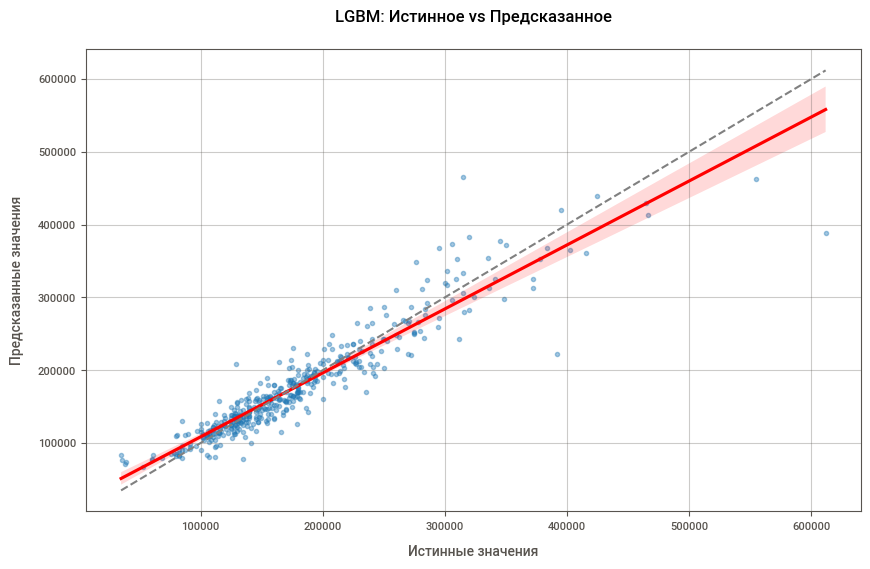

In [15]:
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4, 'color':'#1f77b4'}, line_kws={'color':'red'})
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray')
plt.title(f'LGBM: Истинное vs Предсказанное', pad=20)
plt.xlabel('Истинные значения', labelpad=10)
plt.ylabel('Предсказанные значения', labelpad=10)
plt.grid(alpha=0.3)
plt.show()

А вот и причина высокого RMSE. Модель сильно и систематически  занижает стоимость дорогого жилья. Предсказания по жилью низкого и среднего ценового сегмента близки к эталону. Скорее всего причина в недостатке записей с высокой стоимостью жилья. Модели почти не на чем было учиться.

На всякий случай взглянем также на это с другой стороны. Посмотрим распределение ошибок на гистограмме.

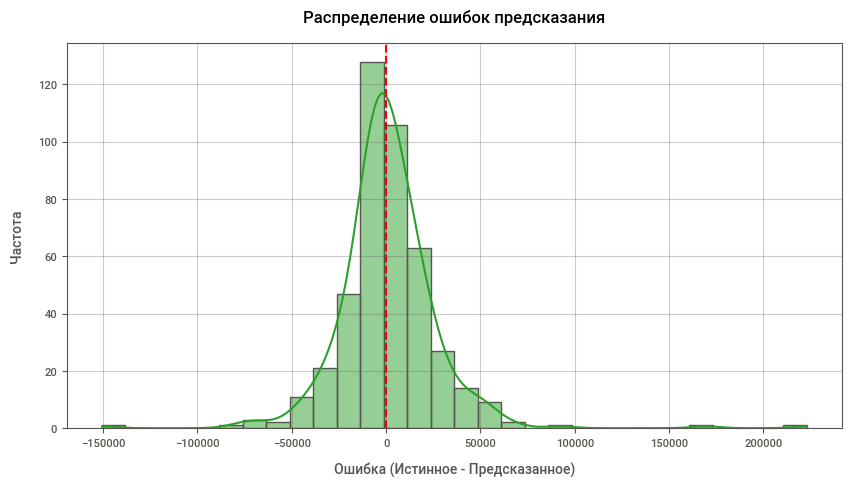

In [16]:
plt.figure(figsize=(10, 5))
errors = y_test - y_pred
sns.histplot(errors, kde=True, bins=30, color='#2ca02c')
plt.title('Распределение ошибок предсказания', pad=15)
plt.xlabel('Ошибка (Истинное - Предсказанное)', labelpad=10)
plt.ylabel('Частота', labelpad=10)
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

Распределение близко к нормальному, здесь проблем нет.

Мы проверили качество модели, но пока не рассматривали из чего оно формируется. Проверим какие признаки вносят наибольший вклад в решения модели.  
Для интерпритации используем shap-графики. На графике beeswarm рассмотрим общую важность признаков, а на графике waterfall проследим за решением на основе одной конкретной записи.

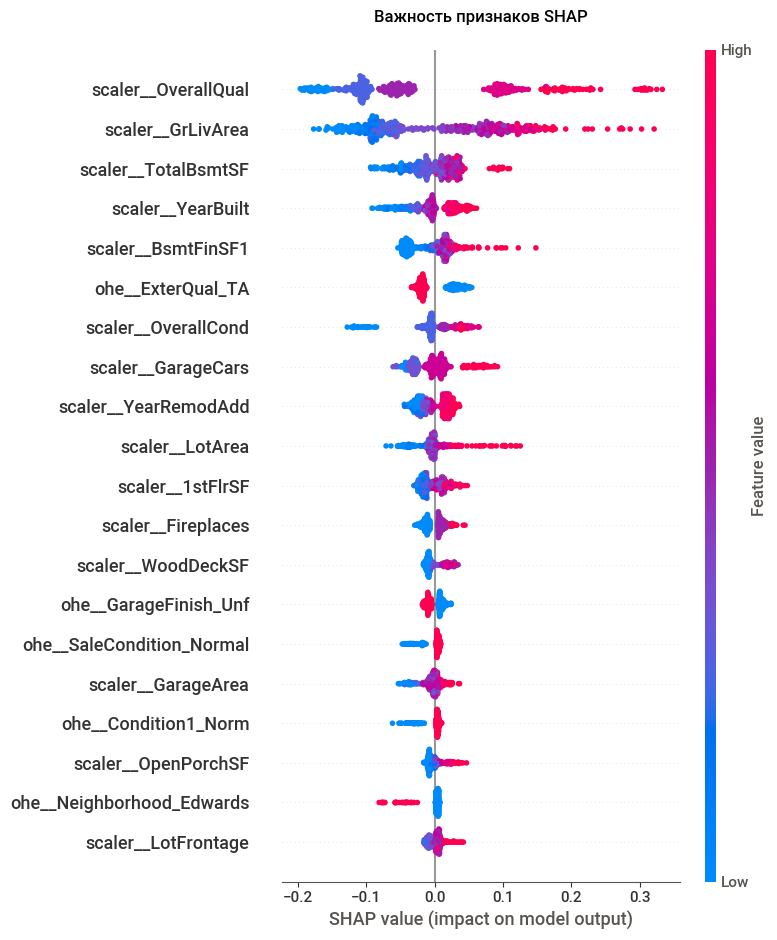

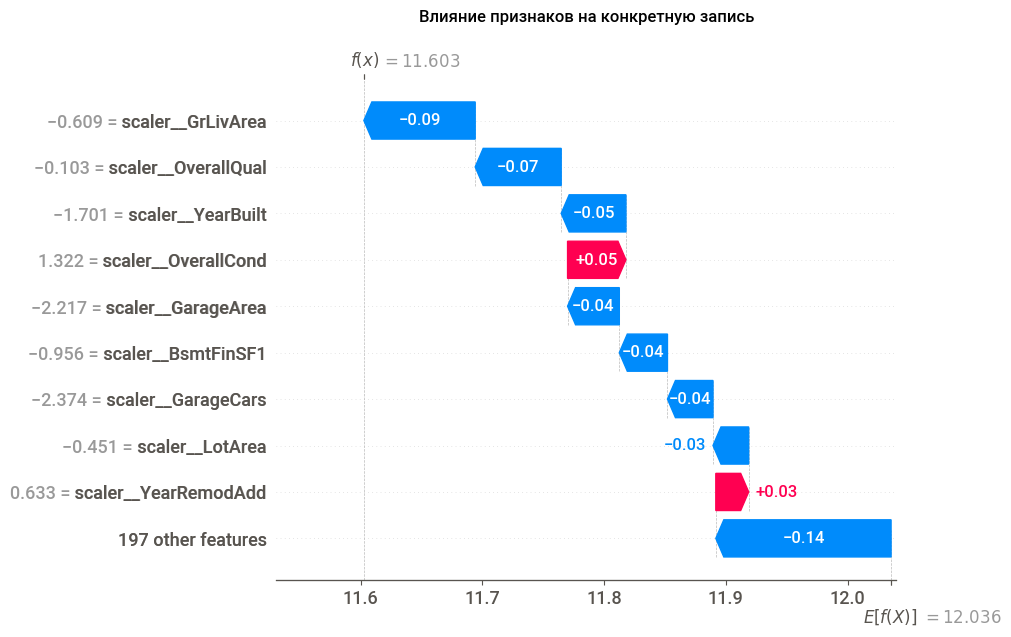

In [17]:
explainer = shap.TreeExplainer(lgbm_cv.best_estimator_.named_steps['model'])
preprocessor.fit(X_train)
X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out(),
    index=X_test.index 
)


shap_values = explainer.shap_values(X_test_transformed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, plot_type="dot", show=False, feature_names=preprocessor.get_feature_names_out())
plt.title('Важность признаков SHAP', pad=20)
plt.tight_layout()
plt.show()

plt.title('Влияние признаков на конкретную запись', pad=20)
shap.plots.waterfall(shap.Explanation(
    values=shap_values[42], 
    base_values=explainer.expected_value, 
    data=X_test_transformed.iloc[42], 
    feature_names=preprocessor.get_feature_names_out()
))


Наибольший вклад вносят показатели площади жилья и десятибальная оценка общего качества, что звучит логично. Чем выше показатели обоих признаков - тем  модель более склонна отнести жильё к дорогому.

На этом финальное тестирование завершается. Итого, мы: 
- Обучили модель на всей тренировочной выборке;
- Вывели показатели четырёх метрик на тестовых данных: MAE, RMSE, R2 и MAPE. По метрикам можно сделать вывод, что модель хорошо справляется со своими обязанностями.
- Построили график соотношения истинных и предсказанных значений тестовых данных, выявили аномальные значения ошибок и систематическое занижение предсказанных значений на дорогом жилье.
- Построили гистограмму распределения ошибок предсказания, убедились в нормальности распределения.
- Построили два SHAP-графика для оценки важности признаков и выявили наиболее ценные признаки - `GrLivArea` и `OverallQual`

## Итоговый вывод

**В рамках разведочного анализа и предобработки, мы:**
- Ознакомились с данными, выявили потенциальные проблемы и малоинформативные признаки;
- Подготовили инструменты автоматической предобработки данных.

**В рамках обучения моделей, мы:**
- Обучили, подобрали параметры и провели кросс-валидацию для трёх разнообразных моделей машинного обучения;
- Выявили лучшую модель - Лёгкий градиентный бустинг.

**В рамках итогового тестирования, мы:**
- Ознакомились с метриками MAE, RMSE, R2 и MAPE;
- Выявили проблему недостатка данных о дорогом жилье в выборке;
- Выявили наиболее информативные признаки - размер жилья и общая оценка качества;

**Рекомендации заказчику:**
- Дополнить данные записями о более разнообразном по стоимости жилье для улучшения качества предсказаний.